In [1]:
import pandas as pd
from tnseq2.src.analysis import *
from pathlib import Path
import plotnine as p9
import seaborn as sns
from sklearn.decomposition import PCA


import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()




import dash_bio as dashbio


In [2]:
root = "/Users/ansintsova/git_repos/nguyenb_tnseq/data/13_04_results"
counts = 'counts'
results = 'results'
control_file = Path(root)/'controls.txt'

In [3]:
dnaids = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid2015', 'dnaid2016', 'dnaid2017', 'dnaid2018', 'dnaid2019',
         'dnaid2023', 'dnaid2024', 'dnaid2025', 'dnaid2026', 'dnaid2027', 'dnaid2028', 'dnaid2029' ]

def load_merged_results(results_dir):
    df = pd.concat([pd.read_csv(file, index_col=0) for file in results_dir.iterdir() if 'merged_results.csv' in file.name])
    return df

def load_singltons(results_dir):
    singles = ['dnaid1315', 'dnaid1428', 'dnaid1429', 'dnaid2019', 'dnaid2027']
    df_list = []
    for s in singles:
        df = pd.read_csv(Path(results_dir)/f'{s}_final_results.csv').assign(dnaid=s)
        df = df.rename({'Unnamed: 0': 'gene'}, axis =1)
        df_list.append(df)
    
    return pd.concat(df_list)
    
    
def get_results(results_dir):
    df = load_merged_results(Path(root)/results)
    df2 = load_singltons(Path(root)/results)
    return pd.concat([df, df2])

results_df = get_results(Path(root)/results)
cnt_df = load_files(dnaids, Path(root)/counts)

## Find all experiments that were done with the same library

In [4]:
results_df[['library', 'experiment', 'dnaid']].drop_duplicates().dropna().groupby('library').experiment.apply(list)

library
library_10_1                       [TV4570]
library_10_2    [TV4592A, TV5585A, TV5563A]
library_11_1              [TV3379, TV3371B]
library_11_2                       [TV4518]
library_12_1                      [TV5585B]
library_12_2             [TV5585C, TV5563B]
library_13_1                      [TV5490A]
library_13_2                      [TV5490B]
library_14_2    [TV5536B, TV4592B, TV5490C]
library_15_1             [TV5536C, TV3652B]
library_9_1              [TV5536A, TV3652C]
Name: experiment, dtype: object

- Libraries library_10_2 and library_14_2 were each used in 3 different experiments. Use that as starting point
- Let's also look at overlap between those 2 libraries (at a gene level)
    - As shown below, overlap is not huge, working with each individually. Later can look at those 632 genes.

In [5]:
overlap_10_14 = results_df.copy()
overlap_10_14 = overlap_10_14[overlap_10_14.library.isin(['library_10_2', 'library_14_2'])]

In [6]:
grouped = overlap_10_14.groupby('gene').library.nunique()
print(f"Overlap is {grouped[grouped >1].shape[0]} genes")

Overlap is 632 genes


In [5]:
lib10=results_df[results_df.library == 'library_10_2'].copy()
lib14=results_df[results_df.library == 'library_14_2'].copy()

In [6]:
print(f"Library 10_2 has {lib10.gene.nunique()} genes")
print(f"Library 14_2 has {lib14.gene.nunique()} genes")

Library 10_2 has 1901 genes
Library 14_2 has 1549 genes


## Analysis Plan

### PCA: 

- Let's look only at barcodes present > 1000 in the inoculum

    - based raw counts
    - mean normalized relative abundances
    - based on relative abundances
    - based on vst transformed counts
    - based on clr transformed counts
    - based on log2FC for each barcode
    - based on z-score for each gene

## Raw Counts

In [7]:
lib10_cnt = cnt_df[cnt_df.library == 'library_10_2'].copy()
lib10_cnt = lib10_cnt[['barcode', 'sampleID', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
lib10_cnt['sampleID'] = lib10_cnt['sampleID']+ "_" + lib10_cnt['dnaid'] + '_' + lib10_cnt['experiment']
lib10_sdata = lib10_cnt[['sampleID', 'mouse', 'day', 'tissue', 'dnaid', 'experiment']].set_index('sampleID').drop_duplicates()
lib10_cnt = lib10_cnt.pivot(index='barcode', columns='sampleID', values='cnt')
lib10_cnt = lib10_cnt.fillna(0)
columns_to_filter = [f for f in lib10_cnt.columns if 'inoculum' in f]
lib10_cnt = lib10_cnt[(lib10_cnt[columns_to_filter] >= 1000).all(1)]

## Scaled Raw Counts

In [11]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
lib10_relab = lib10_cnt.copy().apply(lambda x: x/x.sum())
lib10_cnt_robust = pd.DataFrame(scaler.fit_transform(lib10_relab.T).T)
lib10_cnt_robust.columns = lib10_cnt.columns
lib10_cnt_robust.index = lib10_cnt.index
lib10_cnt_robust.head()
#pDf_robust, pc1_robust, pc2_robust = find_pc1_pc2(lib10_cnt_robust, lib10_sdata)
#plotPCA(pDf_robust, pc1_robust, pc2_robust, colorby='experiment', nameby='mouse', col=list(sns.color_palette()));

sampleID           ad926_d1_dnaid2017_TV4592A  ad926_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                    0.545328                    0.476490   
AAAAAACGTCCGCGATG                   -0.110256                    0.267910   
AAAAACATGCCACACTG                    0.285429                    0.207215   
AAAAACTTTATACTTGA                    0.040689                    0.506533   
AAAAAGTCCCGATGCAA                   -0.048139                    0.000037   

sampleID           ad926_d3_dnaid2018_TV4592A  ad926_d4_dnaid2018_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   -0.512081                   -0.421405   
AAAAAACGTCCGCGATG                    0.544466                    0.461402   
AAAAACATGCCACACTG                    0.218979                    0.461468   
AAAAACTTTATACTTGA                    0.132404                    0.096128   
AAAAAGTCCCGATGCAA                   -0.322116                   -0.383774   

sampleID           ad927_d1_dnaid2017_TV4592A  ad927_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                    0.307478                    0.637290   
AAAAAACGTCCGCGATG                   -0.613675                   -0.424320   
AAAAACATGCCACACTG                   -0.853342                   -0.875225   
AAAAACTTTATACTTGA                   -0.743297                   -0.665347   
AAAAAGTCCCGATGCAA                    0.616436                    0.618869   

sampleID           ad927_d3_dnaid2018_TV4592A  ad927_d4_dnaid2018_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                   -0.003096                   -0.094568   
AAAAAACGTCCGCGATG                   -0.158838                   -0.173959   
AAAAACATGCCACACTG                   -0.794309                   -0.812321   
AAAAACTTTATACTTGA                   -0.769016                   -0.799868   
AAAAAGTCCCGATGCAA                    0.336328                    0.201678   

sampleID           ad928_d1_dnaid2017_TV4592A  ad928_d2_dnaid2017_TV4592A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                    0.660313                    0.729993   
AAAAAACGTCCGCGATG                   -0.076126                    0.039526   
AAAAACATGCCACACTG                   -0.114569                    0.086004   
AAAAACTTTATACTTGA                   -0.375428                   -0.162896   
AAAAAGTCCCGATGCAA                    0.340940                    0.309517   

sampleID           ...  am732_d1_dnaid2028_TV5585A  \
barcode            ...                               
AAAAAAACTGTAGTGCA  ...                    1.719053   
AAAAAACGTCCGCGATG  ...                   -1.118058   
AAAAACATGCCACACTG  ...                    1.146336   
AAAAACTTTATACTTGA  ...                   -1.330790   
AAAAAGTCCCGATGCAA  ...                   -1.346408   

sampleID           am732_d2_dnaid2028_TV5585A  am732_d3_dnaid2029_TV5585A  \
barcode                                                                     
AAAAAAACTGTAGTGCA                    9.301253                    7.077349   
AAAAAACGTCCGCGATG                   -1.078405                   -1.013753   
AAAAACATGCCACACTG                   -0.743437                   -0.792943   
AAAAACTTTATACTTGA                   -1.340208                   -1.334719   
AAAAAGTCCCGATGCAA                   -1.349337                   -1.349337   

sampleID           am732_d4_dnaid2029_TV5585A  inoculum_d0_dnaid2017_TV4592A  \
barcode                                                                        
AAAAAAACTGTAGTGCA                    0.869819                       0.083055   
AAAAAACGTCCGCGATG                    2.580878                       0.000000   
AAAAACATGCCACACTG                   -0.816303                

In [12]:
lib10_cnt_robust_noinoc = lib10_cnt_robust[[c for c in lib10_cnt_robust.columns if 'inoculum' not in c]]
#pDf_robust2, pc1_robust2, pc2_robust2 = find_pc1_pc2(lib10_cnt_robust_noinoc, lib10_sdata)
#plotPCA(pDf_robust2, pc1_robust2, pc2_robust2, colorby='day', nameby='mouse', col=list(sns.color_palette()));

## Proportions

- Proportions by themselves are not very informative 
- With RobustScaler can see separation between inoculum and the rest of the samples

In [13]:

#pDf_relab, pc1_relab, pc2_relab = find_pc1_pc2(lib10_relab, lib10_sdata)
#plotPCA(pDf_relab, pc1_relab, pc2_relab, colorby='experiment', nameby='mouse', col=list(sns.color_palette()));

## CLR Transformed Data
- CLR and VST transformed data show very similar results
- Potentially identify mice that are outliers and should be removed? 
- Everything else clusters together

In [14]:
import numpy as np
from skbio.stats.composition import clr
lib10_clr = lib10_cnt.apply(lambda x: clr(x+1))

#pDf_clr, pc1_clr, pc2_clr = find_pc1_pc2(lib10_clr, lib10_sdata)
#plotPCA(pDf_clr, pc1_clr, pc2_clr, colorby='day', nameby='mouse', col=list(sns.color_palette()));

## VST Normalized Data

In [15]:
sdf = lib10_sdata
edf = lib10_cnt[list(sdf.index)]
sdf.to_csv(Path(root)/results/'lib10_sdf.csv')
edf.to_csv(Path(root)/results/'lib10_edf.csv')
# Run DESeq2
lib10_vst = pd.read_csv(Path(root)/results/'lib10_vsd.csv').rename({'Unnamed: 0':'barcode'}, axis=1).set_index('barcode')
#pDf_vst, pc1_vst, pc2_vst = find_pc1_pc2(lib10_vst, lib10_sdata)

#plotPCA(pDf_vst, pc1_vst, pc2_vst, colorby='day', nameby='mouse', col=list(sns.color_palette()));

In [16]:
outliers = ['am732', 'am730', 'am484']
lib10_clr_nooutliers = lib10_clr[[c for c in lib10_clr.columns if 'am732' not in c and 'am730' not in c and 'am484' not in c]]
#pDf_clrNO, pc1_clrNO, pc2_clrNO = find_pc1_pc2(lib10_clr_nooutliers, lib10_sdata)
#plotPCA(pDf_clrNO, pc1_clrNO, pc2_clrNO, colorby='day', nameby='mouse', col=list(sns.color_palette()));

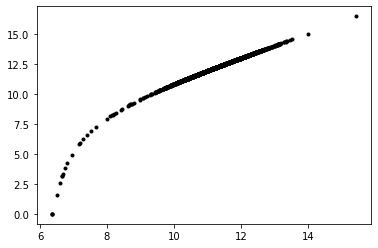

In [17]:
import matplotlib.pyplot as plt

plt.plot(lib10_vst.ad926_d2_dnaid2017_TV4592A, np.log2(lib10_cnt.ad926_d2_dnaid2017_TV4592A+1), '.k')

<AxesSubplot:>

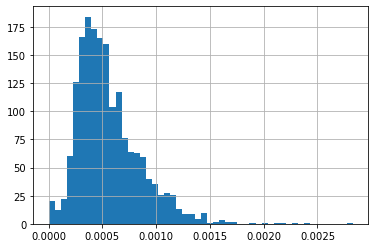

In [18]:
lib10_relab.ad926_d1_dnaid2017_TV4592A.hist(bins=50)

<AxesSubplot:>

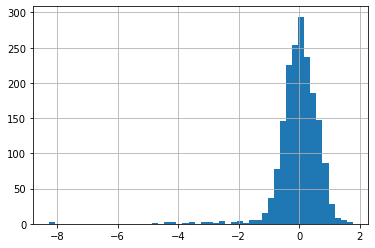

In [109]:
lib10_clr.ad926_d1_dnaid2017_TV4592A.hist(bins=50)

<AxesSubplot:>

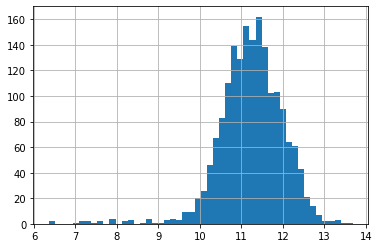

In [25]:
lib10_vst.ad926_d1_dnaid2017_TV4592A.hist(bins=50)

In [37]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))

    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False):
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(25, 15))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(frameon=True)
    return fig


In [19]:
lib10_vst.T.head()

barcode                                   AAAAAAACTGTAGTGCA  \
ad927_d1_dnaid2017_TV4592A                        11.440206   
ad927_d2_dnaid2017_TV4592A                        11.703670   
ad930_d1_dnaid2017_TV4592A                        11.283666   
ad926_d2_dnaid2017_TV4592A                        11.436887   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.299949   

barcode                                   AAAAAACGTCCGCGATG  \
ad927_d1_dnaid2017_TV4592A                        10.619997   
ad927_d2_dnaid2017_TV4592A                        11.062295   
ad930_d1_dnaid2017_TV4592A                        11.269587   
ad926_d2_dnaid2017_TV4592A                        11.843990   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.266161   

barcode                                   AAAAACATGCCACACTG  \
ad927_d1_dnaid2017_TV4592A                         9.964372   
ad927_d2_dnaid2017_TV4592A                         9.889449   
ad930_d1_dnaid2017_TV4592A                        11.725484   
ad926_d2_dnaid2017_TV4592A                        11.888580   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.423470   

barcode                                   AAAAACTTTATACTTGA  \
ad927_d1_dnaid2017_TV4592A                        10.435232   
ad927_d2_dnaid2017_TV4592A                        10.615794   
ad930_d1_dnaid2017_TV4592A                        11.187928   
ad926_d2_dnaid2017_TV4592A                        11.803546   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.216691   

barcode                                   AAAAAGTCCCGATGCAA  \
ad927_d1_dnaid2017_TV4592A                        11.111339   
ad927_d2_dnaid2017_TV4592A                        11.138292   
ad930_d1_dnaid2017_TV4592A                        10.533487   
ad926_d2_dnaid2017_TV4592A                        10.491061   
unenriched_inoculum_d0_dnaid2017_TV4592A          10.902243   

barcode                                   AAAACATGTTGCATGCG  \
ad927_d1_dnaid2017_TV4592A                        12.323491   
ad927_d2_dnaid2017_TV4592A                        12.580917   
ad930_d1_dnaid2017_TV4592A                        12.051772   
ad926_d2_dnaid2017_TV4592A                        11.509440   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.598649   

barcode                                   AAAACGCAAATTATACG  \
ad927_d1_dnaid2017_TV4592A                        10.887327   
ad927_d2_dnaid2017_TV4592A                        11.131547   
ad930_d1_dnaid2017_TV4592A                        12.320830   
ad926_d2_dnaid2017_TV4592A                        12.053015   
unenriched_inoculum_d0_dnaid2017_TV4592A          11.865111   

barcode                                   AAAACTTCATGTACAGA  \
ad927_d1_dnaid2017_TV4592A                         8.287804   
ad927_d2_dnaid2017_TV4592A                         8.397549   
ad930_d1_dnaid2017_TV4592A                        10.995990   
ad926_d2_dnaid2017_TV4592A                        10.909922   
unenriched_inoculum_d0_dnaid2017_TV4592A          10.745599   

barcode                                   AAAATCGAGTCAAAGCT  \
ad927_d1_dnaid2017_TV4592A                         9.142560   
ad927_d2_dnaid2017_TV4592A                         9.258038   
ad930_d1_dnaid2017_TV4592A                        10.009825   
ad926_d2_dnaid2017_TV4592A                         9.668653   
unenriched_inoculum_d0_dnaid2017_TV4592A          10.210587   

barcode                                   AAAATCTTGAAATAGTC  ...  \
ad927_d1_dnaid2017_TV4592A                        11.807630  ...   
ad927_d2_dnaid2017_TV4592A                        11.904419  ...   
ad930_d1_dnaid2017_TV4592A                        10.841242  ...   
ad926_d2_dnaid2017_TV4592A                        10.704444  ...   
unenriched_inoculum_d0_dnaid2017_TV4592A          10.829852  ...   

barcode                                   TTTCCTGTCATACACAA  \
ad927_d1_dnaid2017_TV4592A                         8.242379   
ad927_d2_dnaid2017_TV4592A                         7.4

In [21]:
# p9.options.figure_size=(10,15)
# g3 =(p9.ggplot(data=fdf,
#            mapping=p9.aes(x='PC1', y='PC2', color='strain', ))
#     + p9.geom_point(size=3)
#      + p9.facet_wrap("~genotype", ncol=2)
#     + p9.theme_bw()
#     + p9.theme(text=p9.element_text(size=14))
# )

## Clustering

In [22]:
from scipy.cluster.hierarchy import dendrogram, ward

In [118]:
linkage_array = ward(lib10_clr.T)

In [115]:
test = lib10_clr.T
rows = list(test.index)
cols = list(test.columns)

In [121]:
lib10_clr.corr()

sampleID                                  ad926_d1_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  1.000000   
ad926_d2_dnaid2017_TV4592A                                  0.919717   
ad926_d3_dnaid2018_TV4592A                                  0.863925   
ad926_d4_dnaid2018_TV4592A                                  0.828475   
ad927_d1_dnaid2017_TV4592A                                  0.606814   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.613068   
inoculum_d0_dnaid2027_TV5563A                               0.636408   
inoculum_d0_dnaid2028_TV5585A                               0.647384   
inoculum_d0_dnaid2029_TV5585A                               0.648377   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.553770   

sampleID                                  ad926_d2_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.919717   
ad926_d2_dnaid2017_TV4592A                                  1.000000   
ad926_d3_dnaid2018_TV4592A                                  0.956495   
ad926_d4_dnaid2018_TV4592A                                  0.918733   
ad927_d1_dnaid2017_TV4592A                                  0.567920   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.509080   
inoculum_d0_dnaid2027_TV5563A                               0.570453   
inoculum_d0_dnaid2028_TV5585A                               0.581780   
inoculum_d0_dnaid2029_TV5585A                               0.581779   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.460311   

sampleID                                  ad926_d3_dnaid2018_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.863925   
ad926_d2_dnaid2017_TV4592A                                  0.956495   
ad926_d3_dnaid2018_TV4592A                                  1.000000   
ad926_d4_dnaid2018_TV4592A                                  0.979938   
ad927_d1_dnaid2017_TV4592A                                  0.540515   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.475974   
inoculum_d0_dnaid2027_TV5563A                               0.496249   
inoculum_d0_dnaid2028_TV5585A                               0.517270   
inoculum_d0_dnaid2029_TV5585A                               0.516534   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.405232   

sampleID                                  ad926_d4_dnaid2018_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.828475   
ad926_d2_dnaid2017_TV4592A                                  0.918733   
ad926_d3_dnaid2018_TV4592A                                  0.979938   
ad926_d4_dnaid2018_TV4592A                                  1.000000   
ad927_d1_dnaid2017_TV4592A                                  0.538735   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.431030   
inoculum_d0_dnaid2027_TV5563A                               0.462007   
inoculum_d0_dnaid2028_TV5585A                               0.481872   
inoculum_d0_dnaid2029_TV5585A                               0.481405   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.379985   

sampleID                                  ad927_d1_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.606814   
ad926_d2_dnaid2017_TV4592A          

In [134]:
?dashbio.Clustergram

In [125]:
lib10_clr.corr()

sampleID                                  ad926_d1_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  1.000000   
ad926_d2_dnaid2017_TV4592A                                  0.919717   
ad926_d3_dnaid2018_TV4592A                                  0.863925   
ad926_d4_dnaid2018_TV4592A                                  0.828475   
ad927_d1_dnaid2017_TV4592A                                  0.606814   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.613068   
inoculum_d0_dnaid2027_TV5563A                               0.636408   
inoculum_d0_dnaid2028_TV5585A                               0.647384   
inoculum_d0_dnaid2029_TV5585A                               0.648377   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.553770   

sampleID                                  ad926_d2_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.919717   
ad926_d2_dnaid2017_TV4592A                                  1.000000   
ad926_d3_dnaid2018_TV4592A                                  0.956495   
ad926_d4_dnaid2018_TV4592A                                  0.918733   
ad927_d1_dnaid2017_TV4592A                                  0.567920   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.509080   
inoculum_d0_dnaid2027_TV5563A                               0.570453   
inoculum_d0_dnaid2028_TV5585A                               0.581780   
inoculum_d0_dnaid2029_TV5585A                               0.581779   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.460311   

sampleID                                  ad926_d3_dnaid2018_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.863925   
ad926_d2_dnaid2017_TV4592A                                  0.956495   
ad926_d3_dnaid2018_TV4592A                                  1.000000   
ad926_d4_dnaid2018_TV4592A                                  0.979938   
ad927_d1_dnaid2017_TV4592A                                  0.540515   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.475974   
inoculum_d0_dnaid2027_TV5563A                               0.496249   
inoculum_d0_dnaid2028_TV5585A                               0.517270   
inoculum_d0_dnaid2029_TV5585A                               0.516534   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.405232   

sampleID                                  ad926_d4_dnaid2018_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.828475   
ad926_d2_dnaid2017_TV4592A                                  0.918733   
ad926_d3_dnaid2018_TV4592A                                  0.979938   
ad926_d4_dnaid2018_TV4592A                                  1.000000   
ad927_d1_dnaid2017_TV4592A                                  0.538735   
...                                                              ...   
inoculum_d0_dnaid2018_TV4592A                               0.431030   
inoculum_d0_dnaid2027_TV5563A                               0.462007   
inoculum_d0_dnaid2028_TV5585A                               0.481872   
inoculum_d0_dnaid2029_TV5585A                               0.481405   
unenriched_inoculum_d0_dnaid2017_TV4592A                    0.379985   

sampleID                                  ad927_d1_dnaid2017_TV4592A  \
sampleID                                                               
ad926_d1_dnaid2017_TV4592A                                  0.606814   
ad926_d2_dnaid2017_TV4592A          

In [144]:
clustergram= dashbio.Clustergram(
    data=lib10_clr.corr().values,
    return_computed_traces=True,
    row_labels=list(lib10_clr.corr().index),
    column_labels=list(lib10_clr.corr().columns),
#     color_threshold={
#         'row': 250,
#         'col': 700
#     },
    #link_fun = scipy.cluster.hierarchy.ward, 
    height=1000,
    width=1200,
    hidden_labels='column',
    standardize ='none',
    generate_curves_dict=True,
)


{0: ['col', 0],
 1: ['col', 1],
 2: ['col', 2],
 3: ['col', 3],
 4: ['col', 4],
 5: ['col', 5],
 6: ['col', 6],
 7: ['col', 7],
 8: ['col', 8],
 9: ['col', 9],
 10: ['col', 10],
 11: ['col', 11],
 12: ['col', 12],
 13: ['col', 13],
 14: ['col', 14],
 15: ['col', 15],
 16: ['col', 16],
 17: ['col', 17],
 18: ['col', 18],
 19: ['col', 19],
 20: ['col', 20],
 21: ['col', 21],
 22: ['col', 22],
 23: ['col', 23],
 24: ['col', 24],
 25: ['col', 25],
 26: ['col', 26],
 27: ['col', 27],
 28: ['col', 28],
 29: ['col', 29],
 30: ['col', 30],
 31: ['col', 31],
 32: ['col', 32],
 33: ['col', 33],
 34: ['col', 34],
 35: ['col', 35],
 36: ['col', 36],
 37: ['col', 37],
 38: ['col', 38],
 39: ['col', 39],
 40: ['col', 40],
 41: ['col', 41],
 42: ['col', 42],
 43: ['col', 43],
 44: ['col', 44],
 45: ['col', 45],
 46: ['col', 46],
 47: ['col', 47],
 48: ['col', 48],
 49: ['col', 49],
 50: ['col', 50],
 51: ['col', 51],
 52: ['col', 52],
 53: ['col', 53],
 54: ['col', 54],
 55: ['col', 55],
 56: ['col',

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


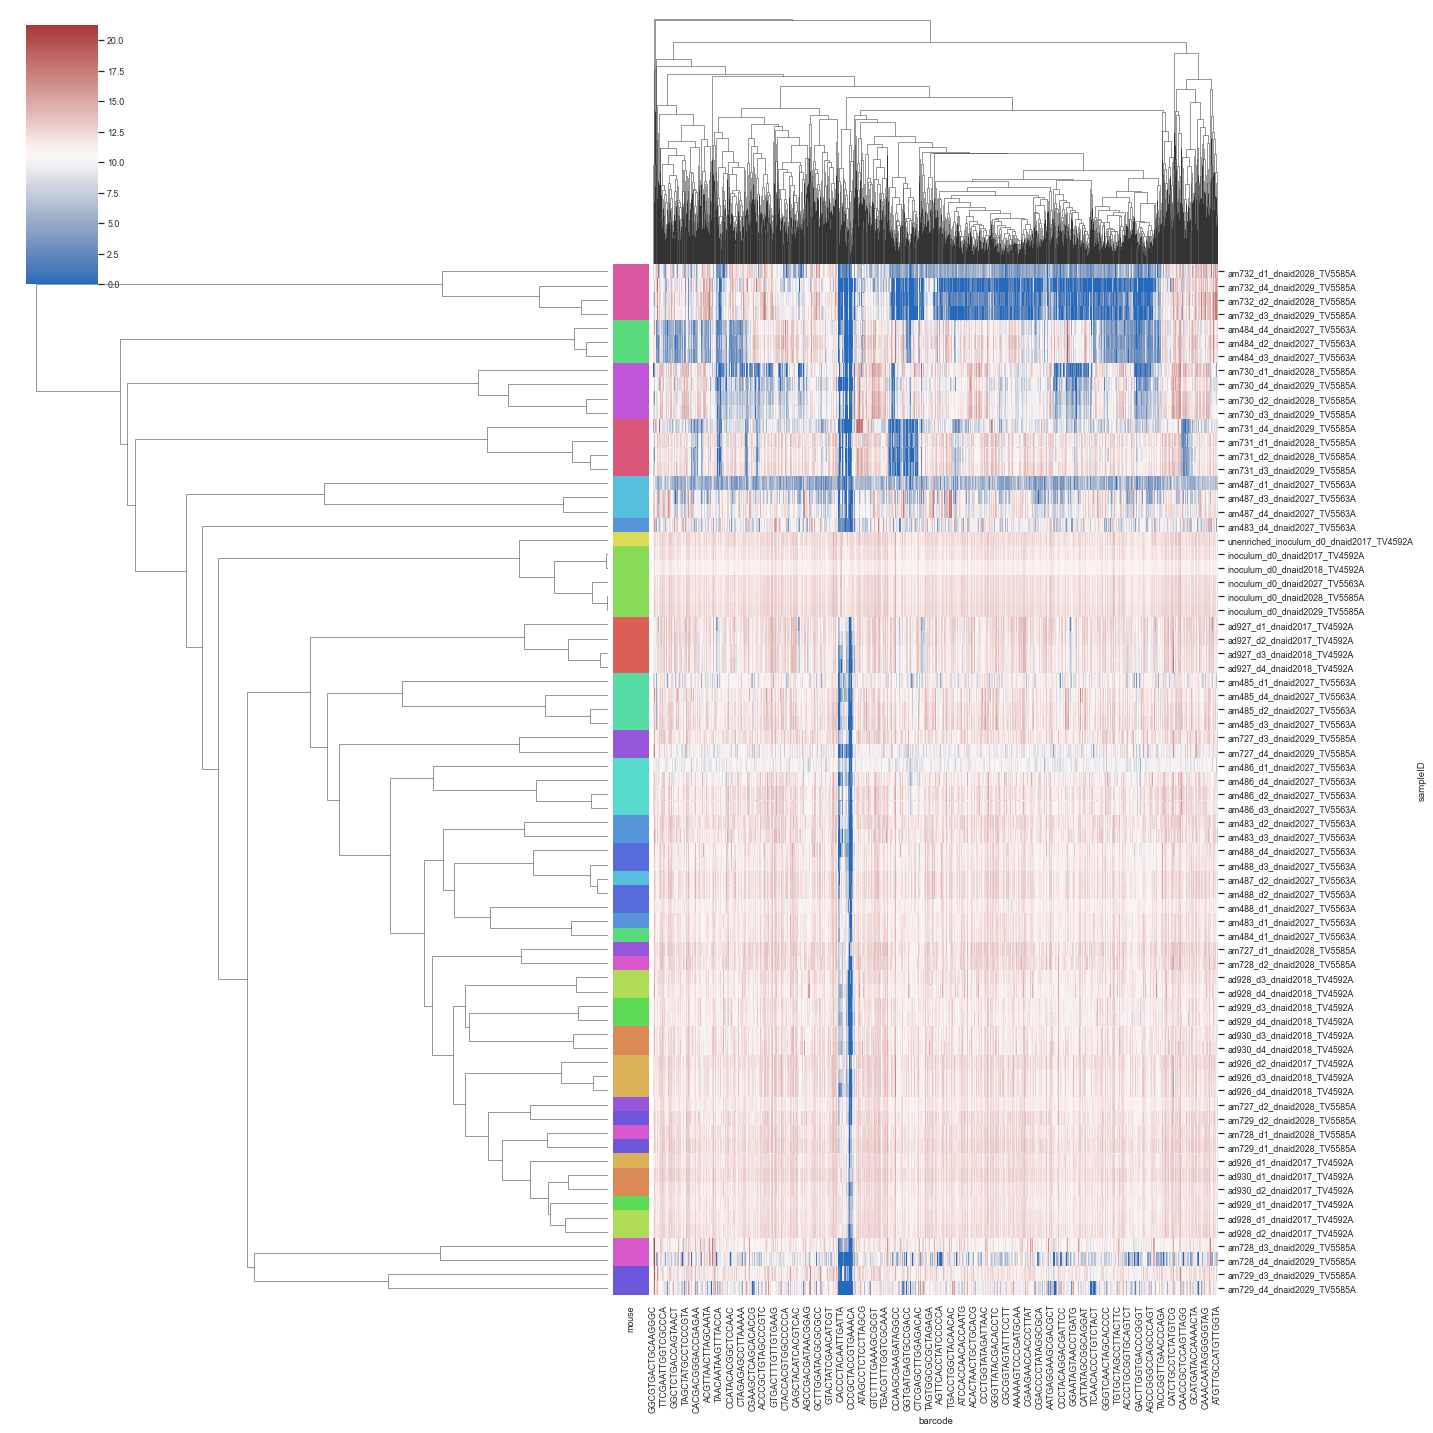

In [558]:
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.mouse.unique(), sns.color_palette("hls", 19)))
row_colors = lib10_sdata.mouse.map(lut)

sns.clustermap(np.log2(lib10_cnt +1).T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")

/Users/ansintsova/opt/miniconda3/envs/mi/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



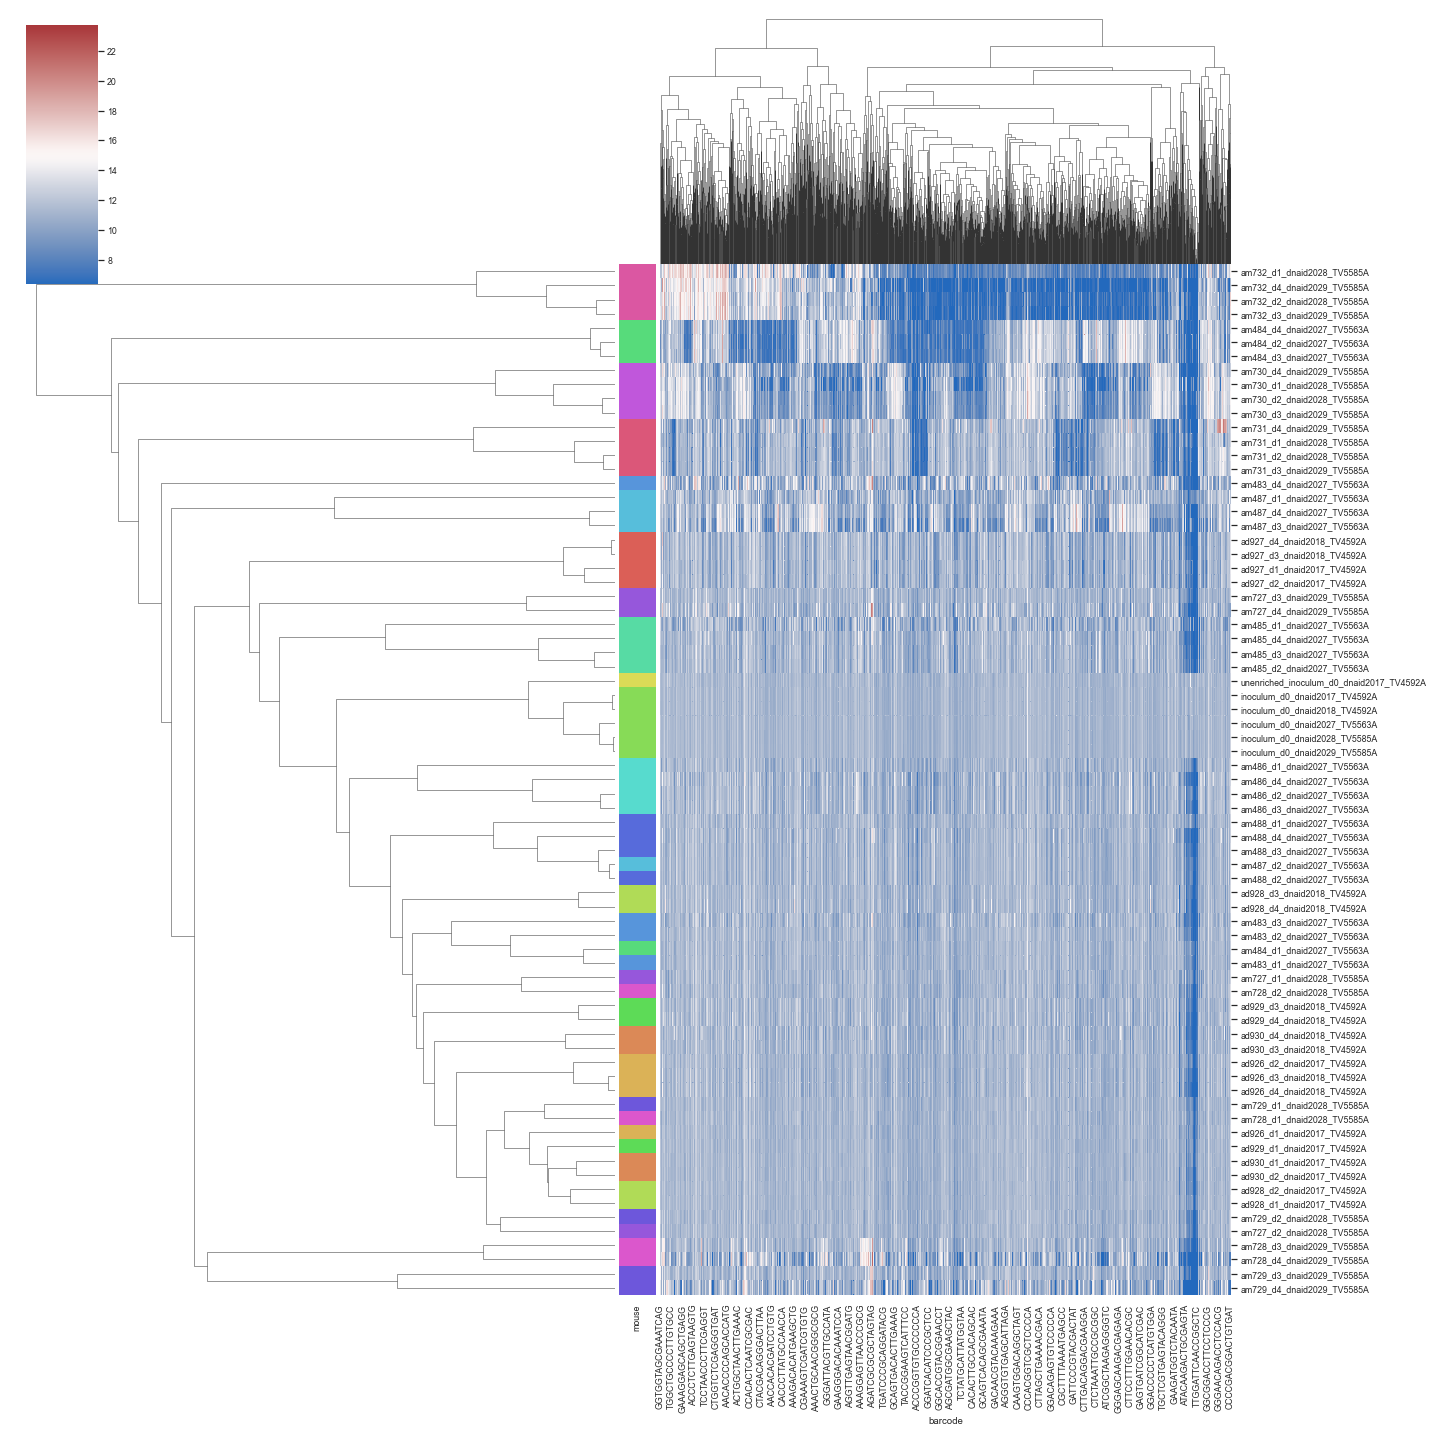

In [119]:
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.mouse.unique(), sns.color_palette("hls", 19)))
row_colors = lib10_sdata.mouse.map(lut)

sns.clustermap(lib10_vst.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")

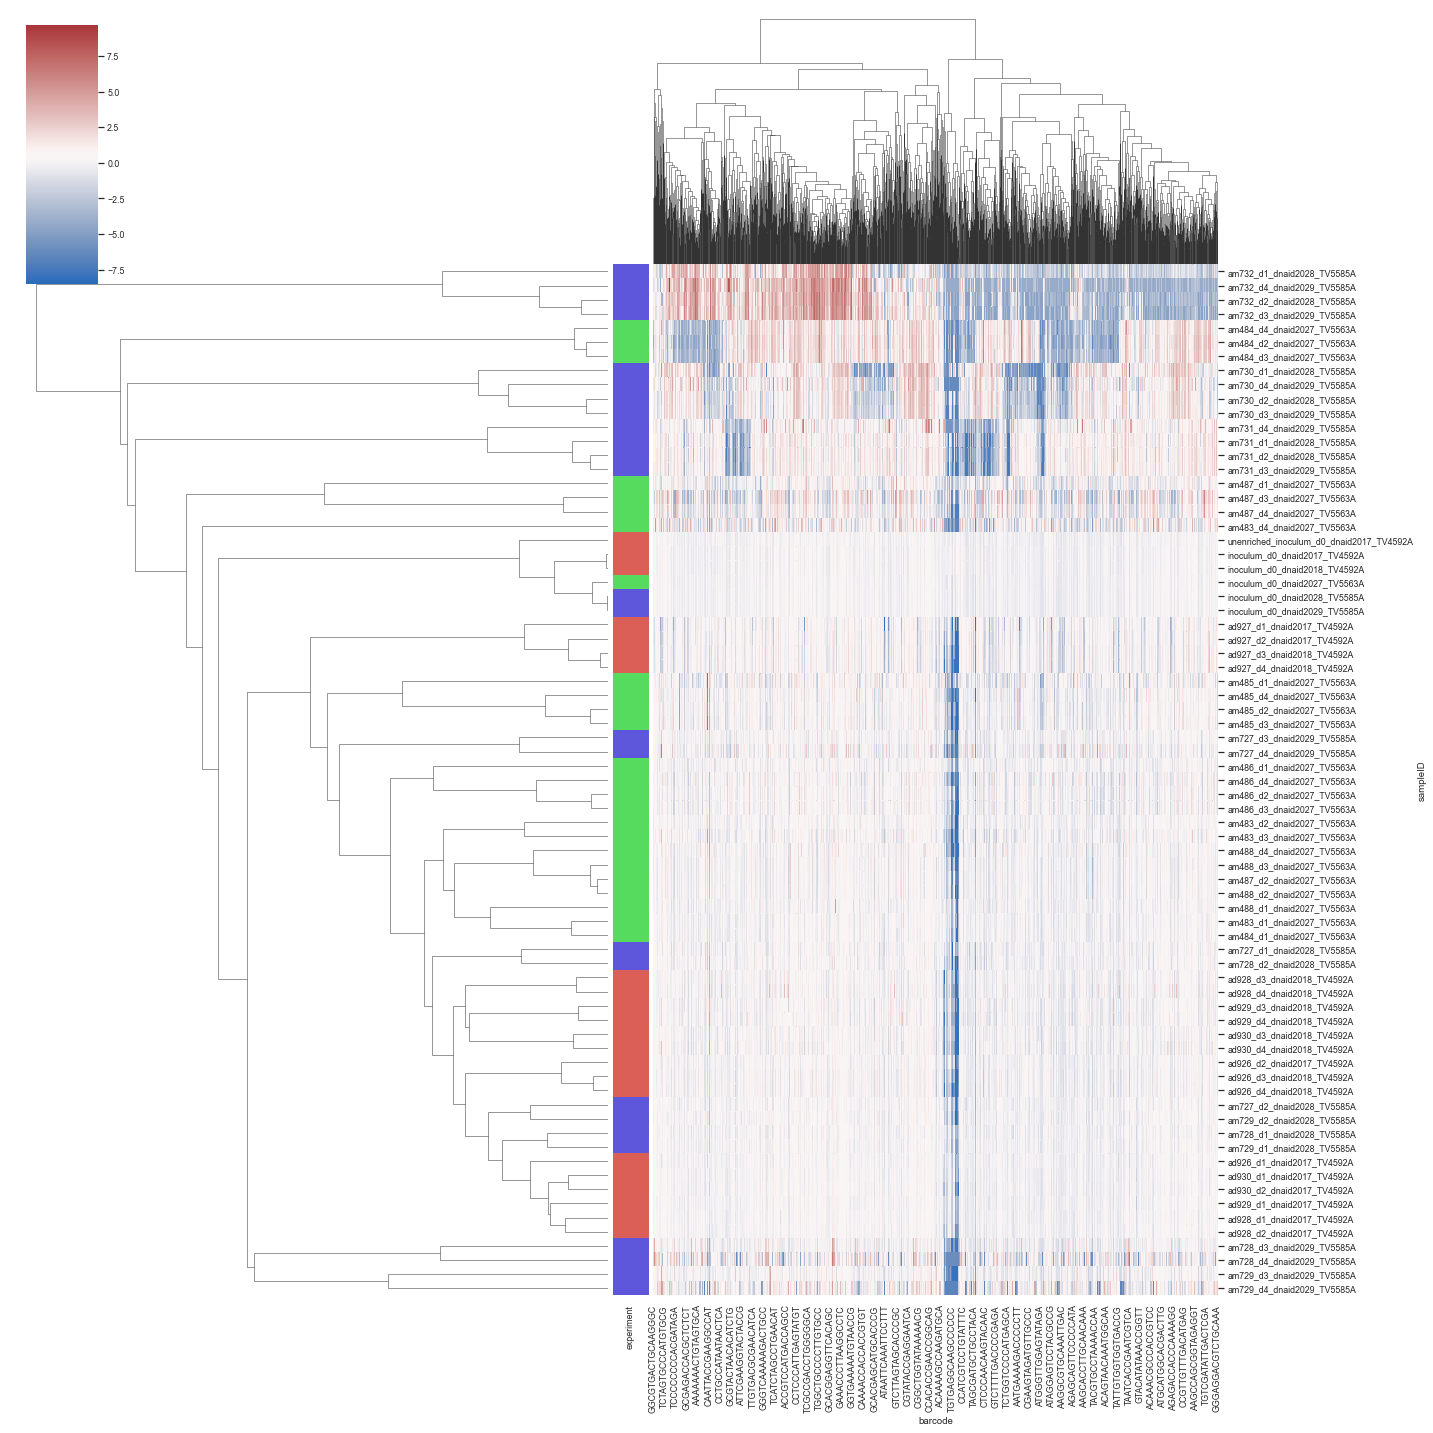

In [518]:
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.experiment.unique(), sns.color_palette("hls", 3)))
row_colors = lib10_sdata.experiment.map(lut)

sns.clustermap(lib10_clr.T, method='average', metric='correlation', 
               figsize=(20, 20), row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap='vlag')

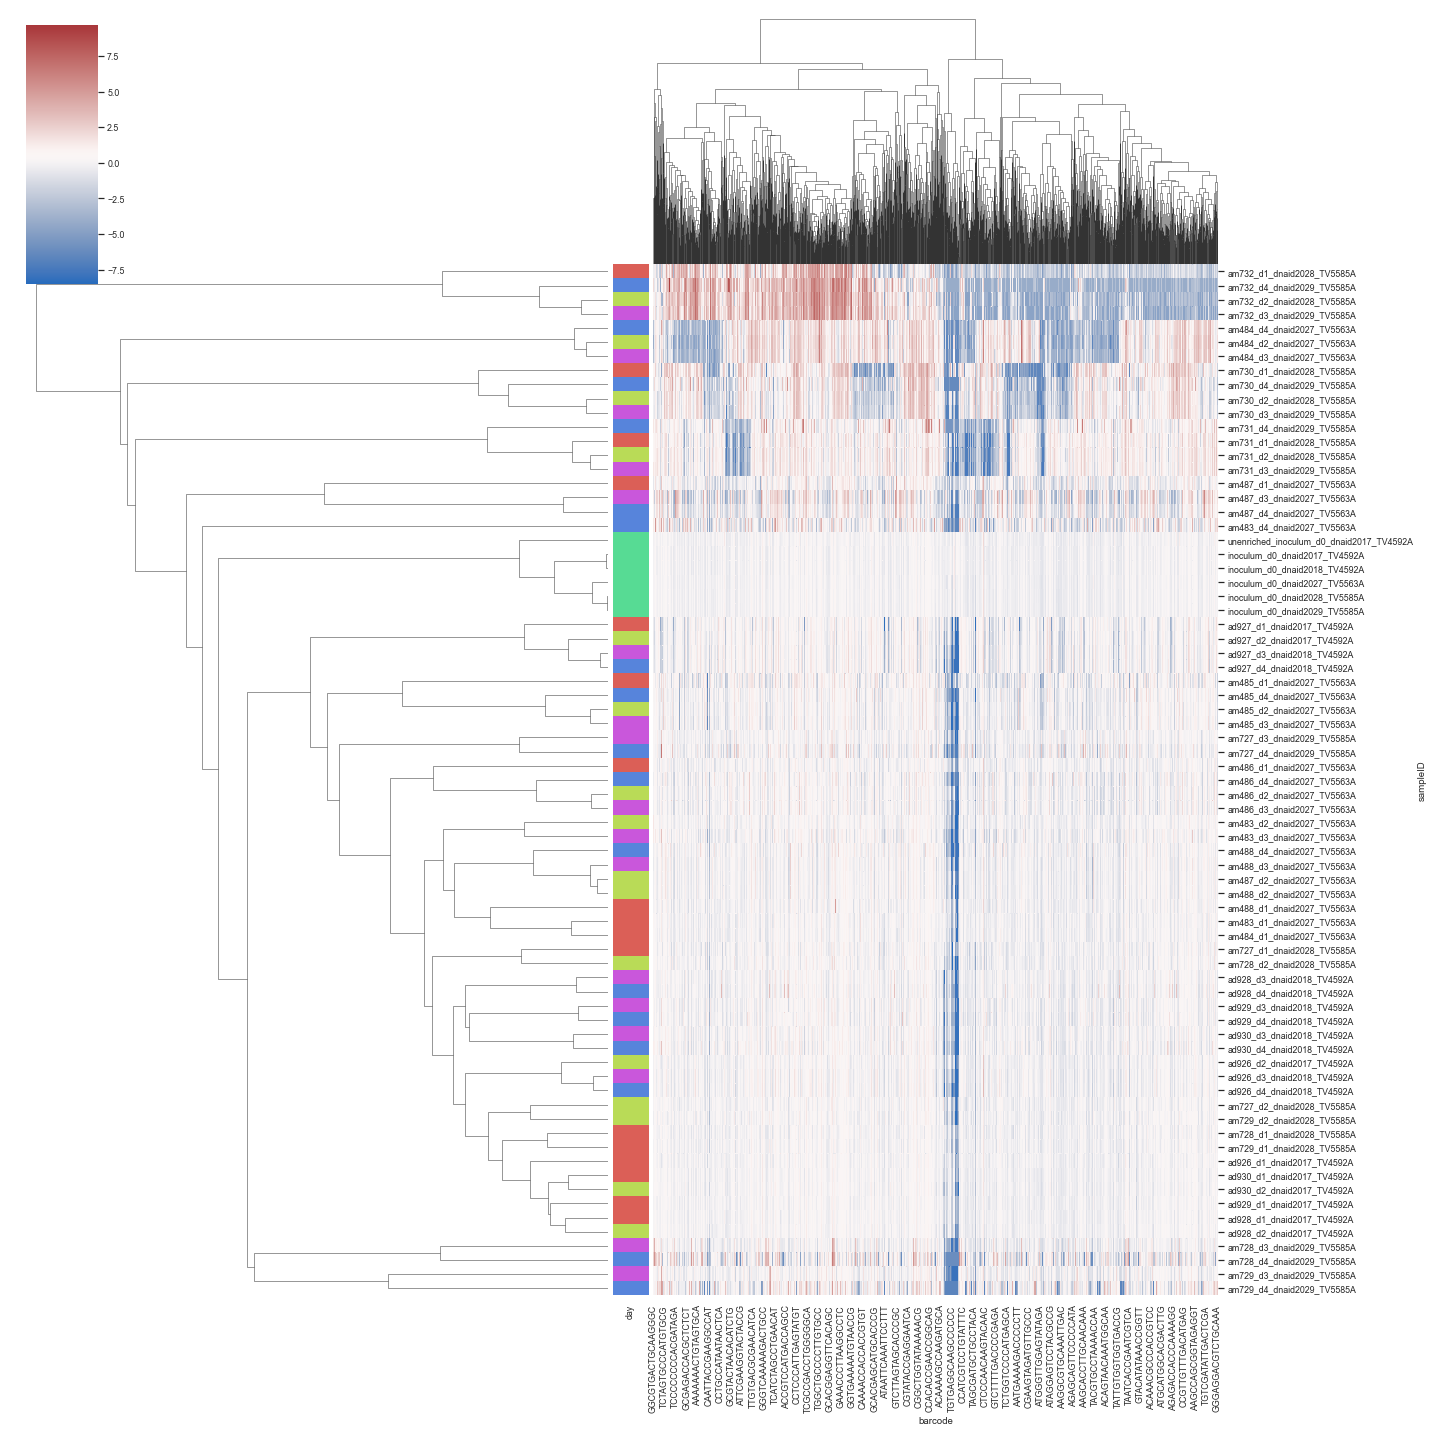

In [519]:
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.day.unique(), sns.color_palette("hls", 5)))
row_colors = lib10_sdata.day.map(lut)

sns.clustermap(lib10_clr.T, method='average', metric='correlation', figsize=(20, 20), row_colors=row_colors, 
               cmap='vlag', dendrogram_ratio=(0.5,0.2))

In [191]:
# sns.set(font_scale=.8)
# lut = dict(zip(lib10_sdata.day.unique(), sns.color_palette("hls", 5)))
# row_colors = lib10_sdata.day.map(lut)

# sns.clustermap(lib10_clr.T, method='ward', figsize=(20, 20), row_colors=row_colors, dendrogram_ratio=(0.5,0.2))

- Check if the outlier mice have stronger bottlenecks. Surprising, because from day1 are different

## Log2FC for each barcode

- Can't get any meaningful signal here
- Re-run analysis without shrinkage

In [275]:
lib10_res = results_df[results_df.library == 'library_10_2'].copy()
lib10_res = lib10_res[['gene', 'experiment', 'dnaid'] + [c for c in lib10_res.columns if 'fitness_mean' in c]].dropna()


lib10_res = lib10_res.melt(id_vars=['gene', 'experiment', 'dnaid'], var_name='day', value_name='fitness')
lib10_res_samples = lib10_res[abs(lib10_res.fitness) > 1].gene.values
lib10_res['day'] = lib10_res['day'].str.split("_", expand=True)[0]
weird_cases = lib10_res.groupby(['gene', 'day']).experiment.count().reset_index()
weird_cases = weird_cases[weird_cases.experiment > 3].gene.values
lib10_res = lib10_res[lib10_res.gene.isin(lib10_res_samples)]
lib10_res = lib10_res[~lib10_res.gene.isin(weird_cases)].drop_duplicates()

lib10_res['sampleID'] = lib10_res.experiment +"_" + lib10_res.dnaid + '_' + lib10_res.day
lib10_res = lib10_res.pivot(index='gene', columns='sampleID', values='fitness').dropna()

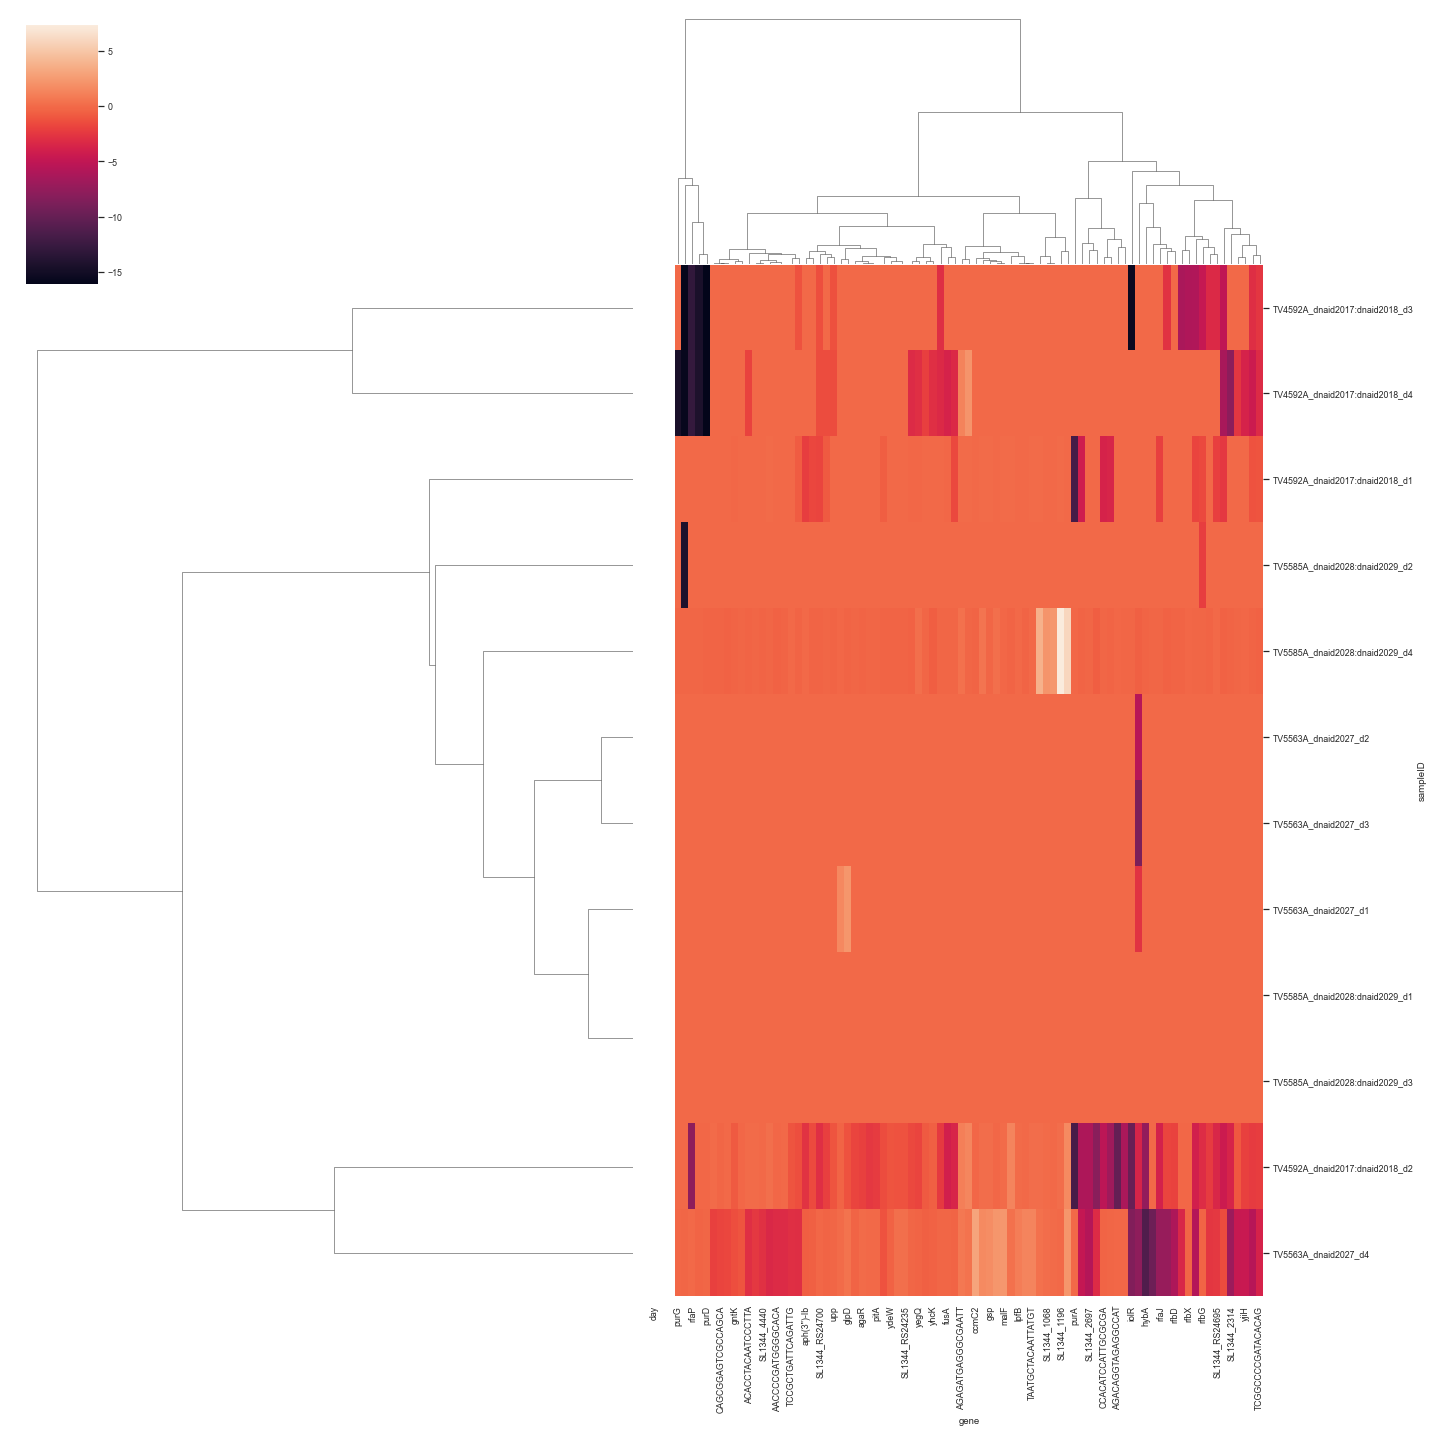

In [277]:
sns.set(font_scale=.8)
sns.clustermap(lib10_res.T, method='ward', 
               figsize=(20, 20), row_colors=row_colors, dendrogram_ratio=(0.5,0.2))

## Control barcodes

In [501]:
controls = pd.read_table(control_file, index_col=0, names = ['barcode', 'phenotype', 'conc'])
controls_bc = controls.barcode.values
#lib10_cntrl_clr = lib10_clr.loc[controls_bc]
#lib10_cntrl_vst = lib10_vst.loc[controls_bc]

In [529]:
wt_cntrs = controls[controls.phenotype == 'wt'].reset_index()['barcode'].values
lib10_wt_cntrl_clr = lib10_cntrl_clr.loc[wt_cntrs]

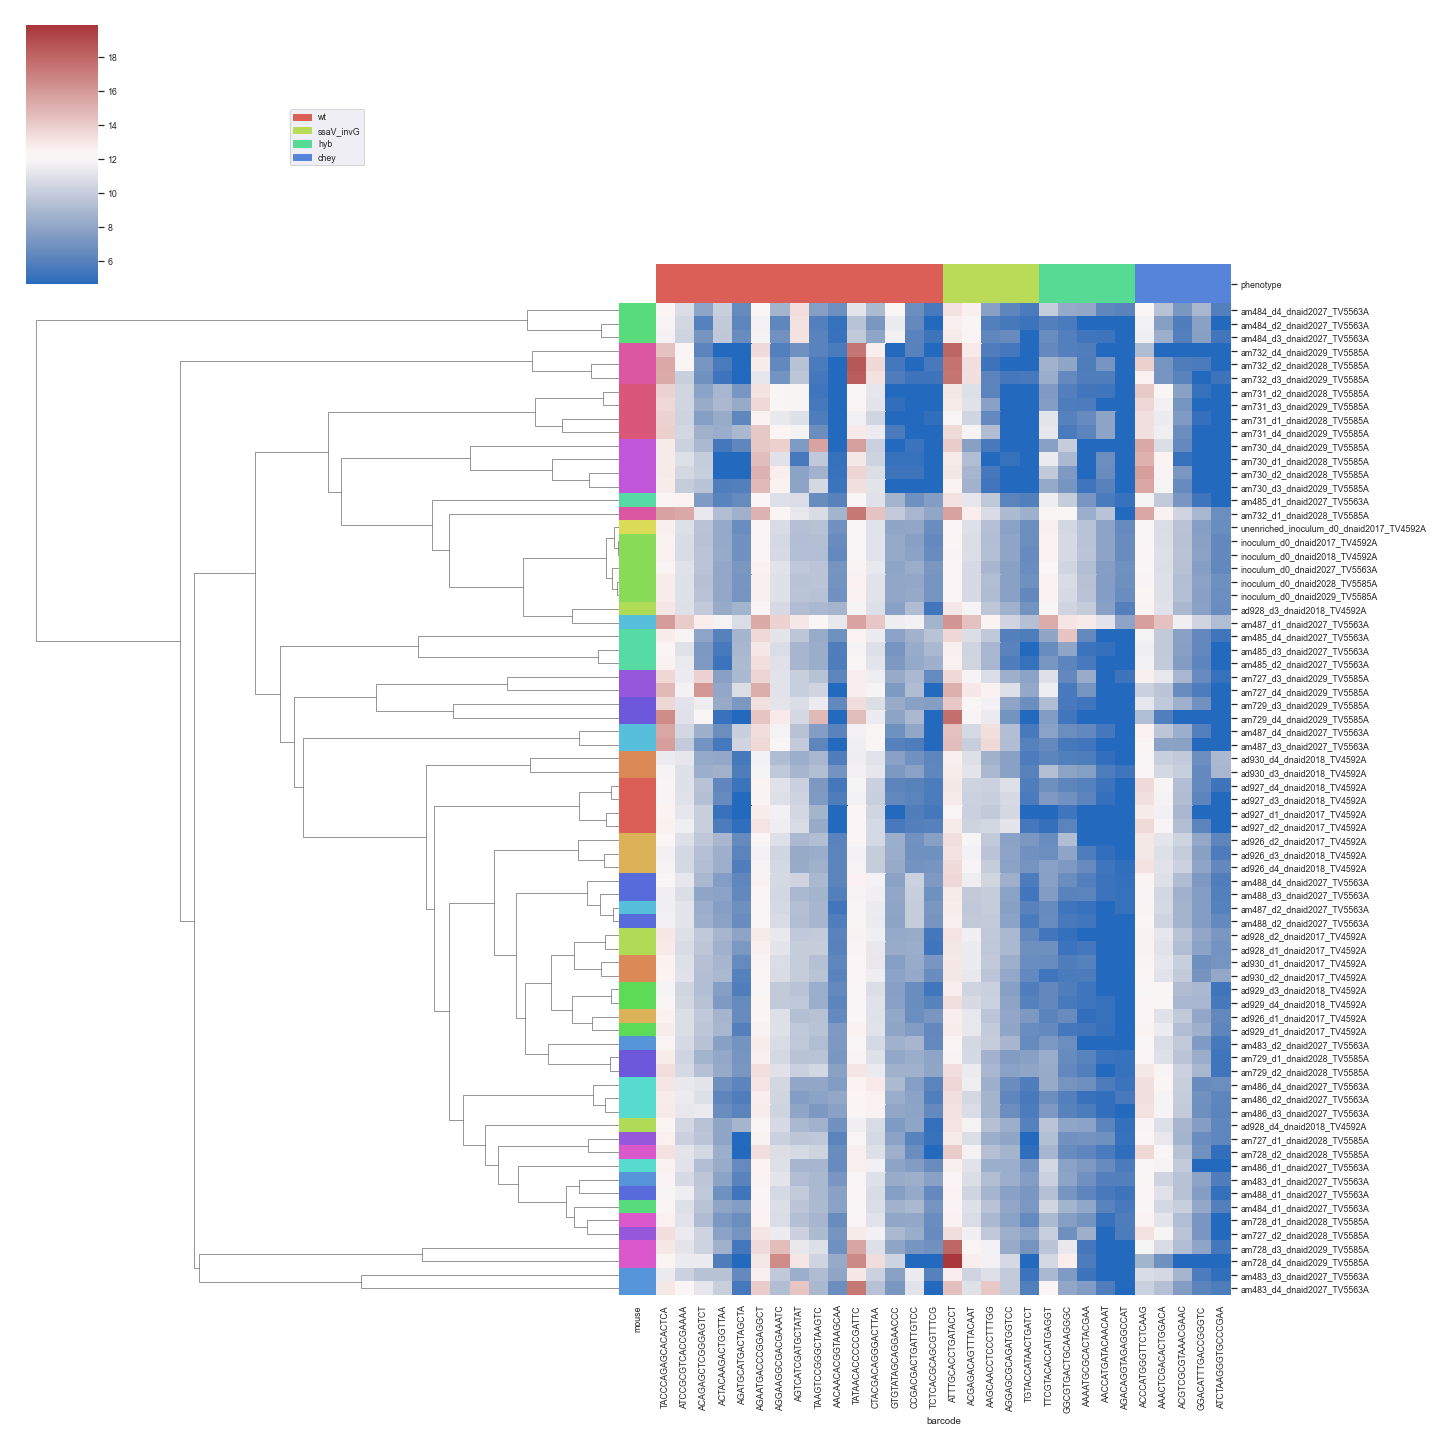

In [500]:
# import matplotlib as mpl
# sns.set(font_scale=.8)
# lut = dict(zip(lib10_sdata.mouse.unique(), sns.color_palette("hls", 19)))
# row_colors = lib10_sdata.mouse.map(lut)
# #controls = controls.set_index('barcode')
# lut2 = dict(zip(controls.phenotype.unique(), sns.color_palette("hls", 5)))
# col_colors = controls.phenotype.map(lut2)

# g = sns.clustermap(lib10_cntrl_vst.T, method='average', metric='correlation', figsize=(20, 20), 
#                row_colors=row_colors,col_cluster=False, col_colors=col_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")


# # Creating Legend
# #function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
# pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in lut2.items()]

# # Displaying function legend
# l2 = g.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(-0.5,1.2), frameon=True)

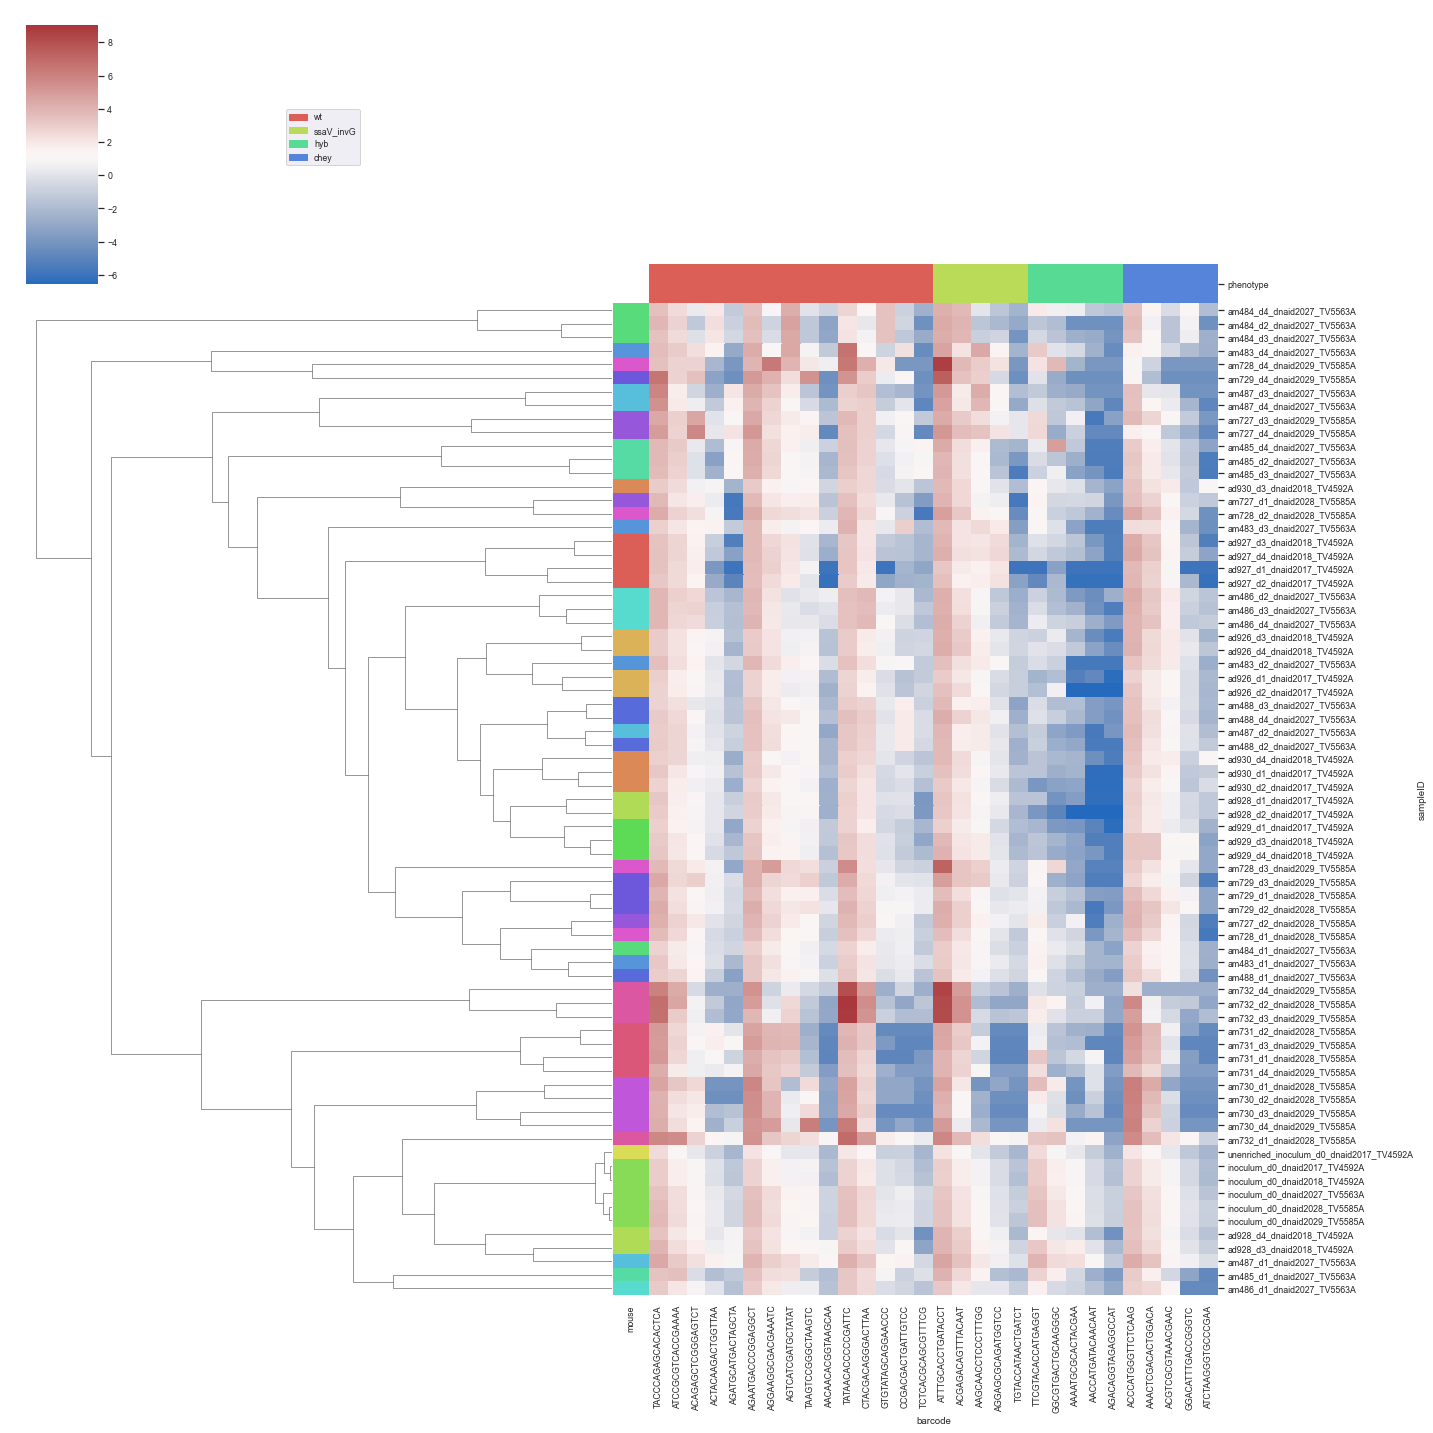

In [504]:
import matplotlib as mpl
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.mouse.unique(), sns.color_palette("hls", 19)))
row_colors = lib10_sdata.mouse.map(lut)
#controls = controls.set_index('barcode')
lut2 = dict(zip(controls.phenotype.unique(), sns.color_palette("hls", 5)))
col_colors = controls.phenotype.map(lut2)

g = sns.clustermap(lib10_cntrl_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors,col_cluster=False, col_colors=col_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")


# Creating Legend
#function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in lut2.items()]

# Displaying function legend
l2 = g.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(-0.5,1.2), frameon=True)

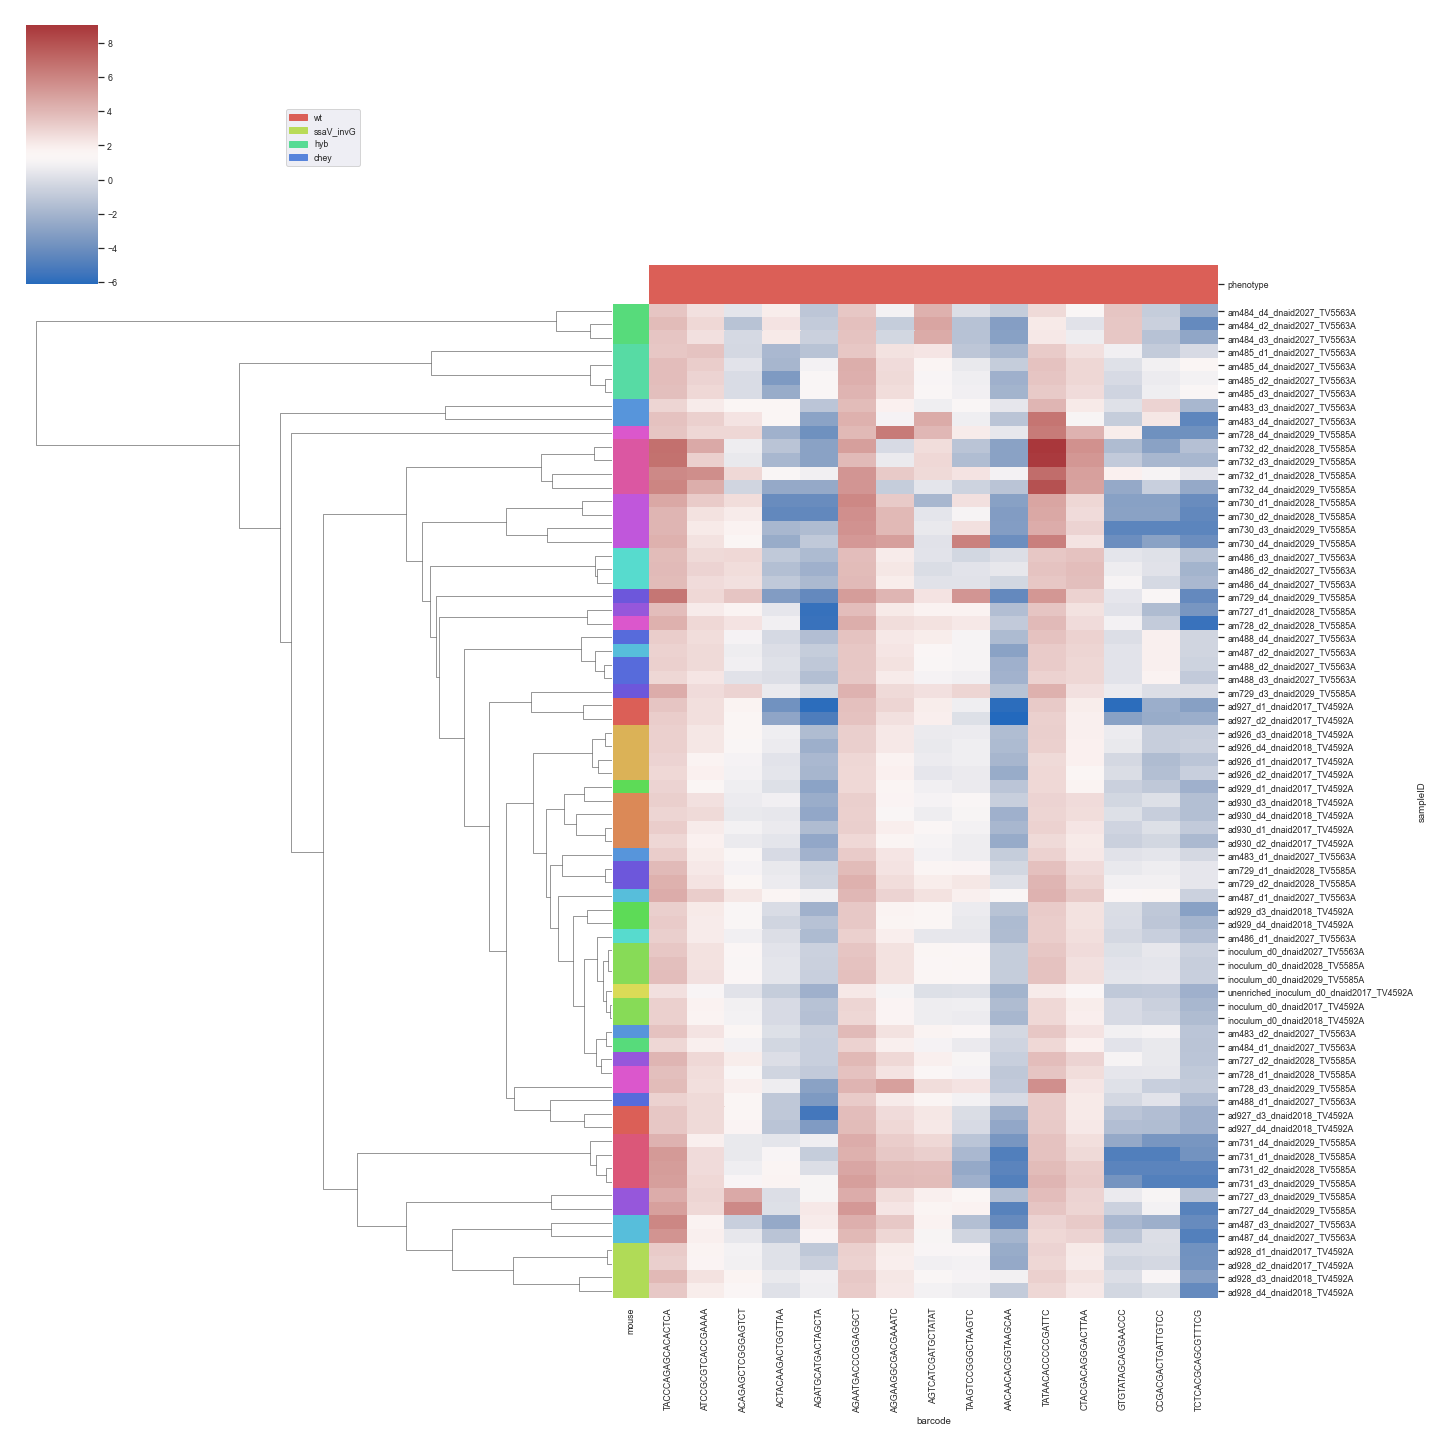

In [531]:
import matplotlib as mpl
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.mouse.unique(), sns.color_palette("hls", 19)))
row_colors = lib10_sdata.mouse.map(lut)
#controls = controls.set_index('barcode')
#lut2 = dict(zip(controls.phenotype.unique(), sns.color_palette("hls", 5)))
#col_colors = controls.phenotype.map(lut2)

g = sns.clustermap(lib10_wt_cntrl_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors,col_cluster=False, col_colors=col_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")


# Creating Legend
#function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in lut2.items()]

# Displaying function legend
l2 = g.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(-0.5,1.2), frameon=True)

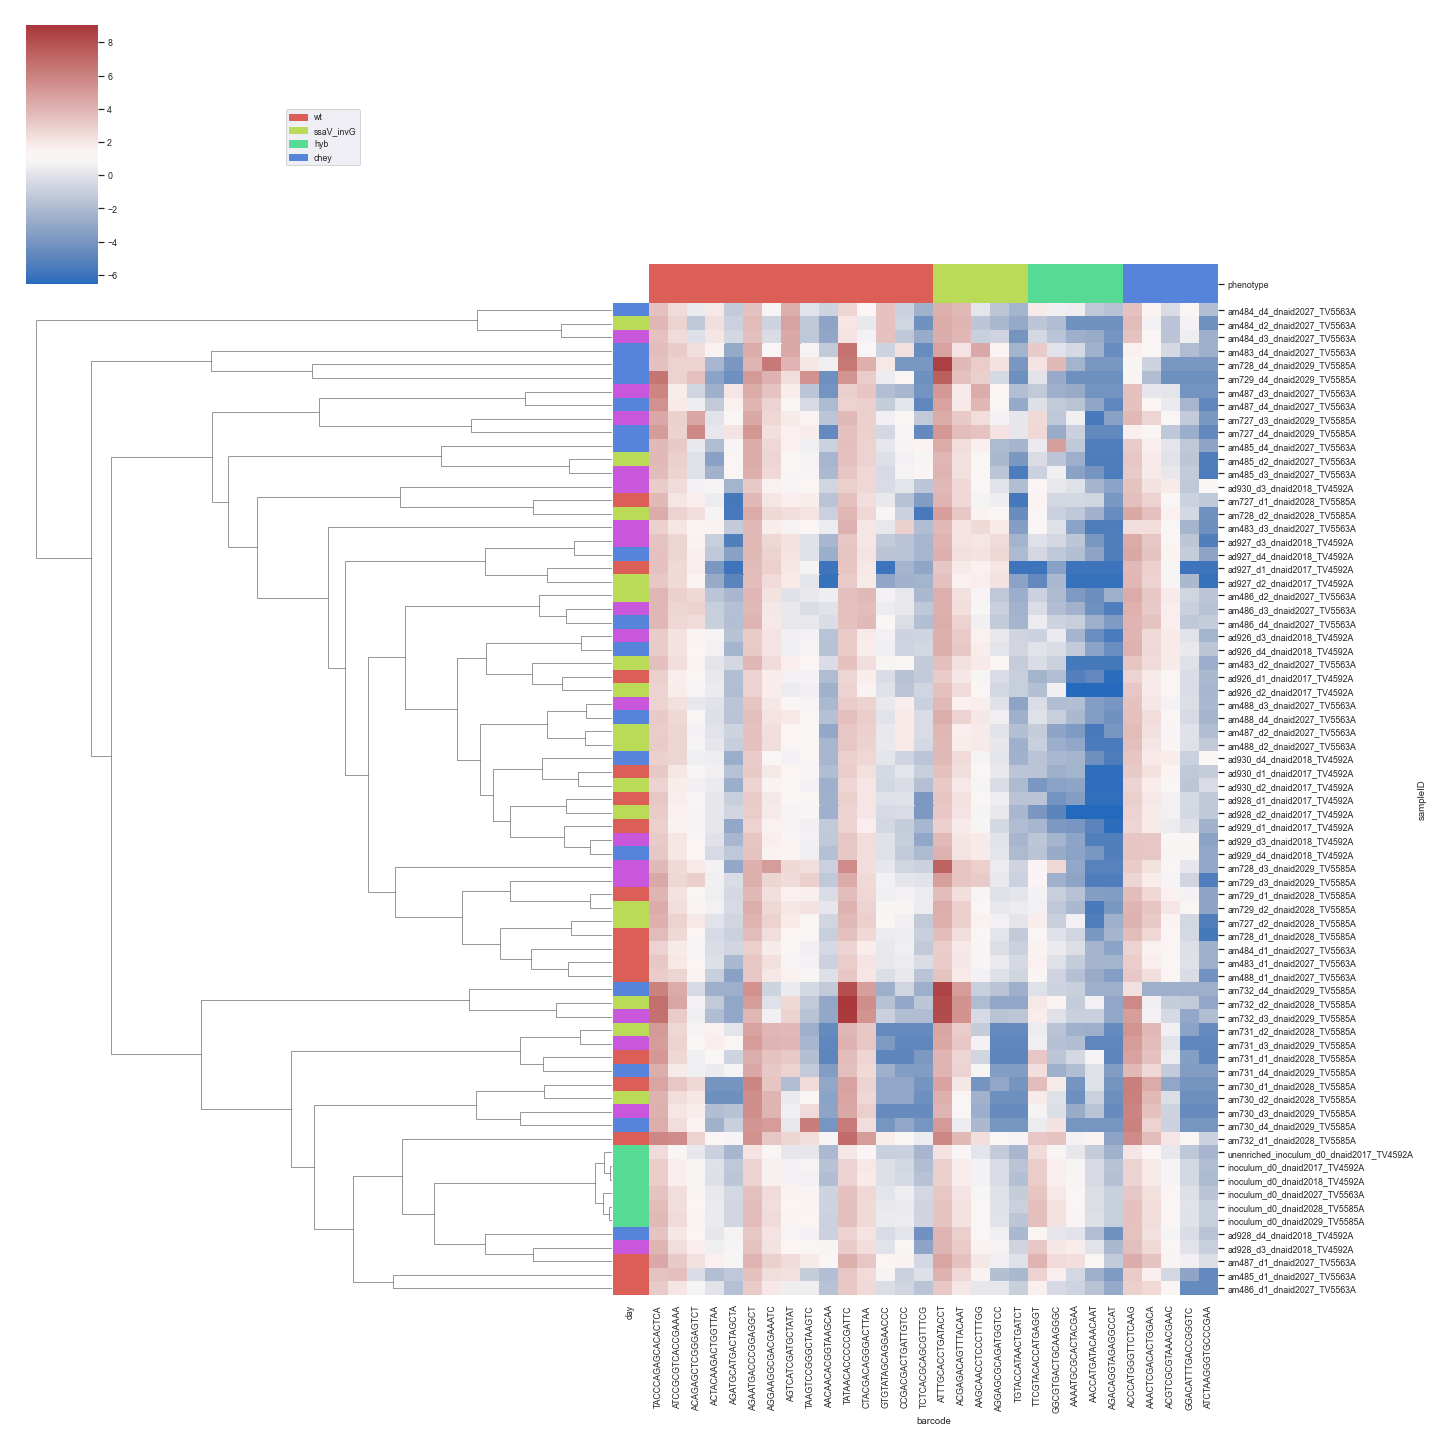

In [520]:
import matplotlib as mpl
sns.set(font_scale=.8)
lut = dict(zip(lib10_sdata.day.unique(), sns.color_palette("hls", 5)))
row_colors = lib10_sdata.day.map(lut)
#controls = controls.set_index('barcode')
lut2 = dict(zip(controls.phenotype.unique(), sns.color_palette("hls", 5)))
col_colors = controls.phenotype.map(lut2)

g = sns.clustermap(lib10_cntrl_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors,col_cluster=False, col_colors=col_colors, dendrogram_ratio=(0.5,0.2), cmap ="vlag")


# Creating Legend
#function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in lut2.items()]

# Displaying function legend
l2 = g.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(-0.5,1.2), frameon=True)

In [532]:
lib10_wt = (cnt_df[(cnt_df.phenotype == 'wt')&(cnt_df.library == 'library_10_2')]
            .copy()[['barcode','cnt', 'conc', 'sampleName', 'experiment', 'dnaid', 'sampleID', 'day', 'mouse']])

lib10_wt['logcnt'] = np.log2(lib10_wt['cnt'])
# corr_df = lib14_wt.groupby(['experiment','sampleID'])[['conc', 'logcnt']].corr().reset_index()
# corr_df = corr_df[corr_df['level_2'] == 'conc'].drop(['level_2', 'conc'], axis=1)
# corr_df.columns = ['experiment','sampleID', 'R']
# corr_df['Rlab'] = corr_df.R.apply(lambda x: f'R = {round(x, 2)}')
# lib14_wt = lib14_wt.merge(corr_df, on=['experiment', 'sampleID'])

lib10_wt.experiment.unique()

array(['TV4592A', 'TV5563A', 'TV5585A'], dtype=object)

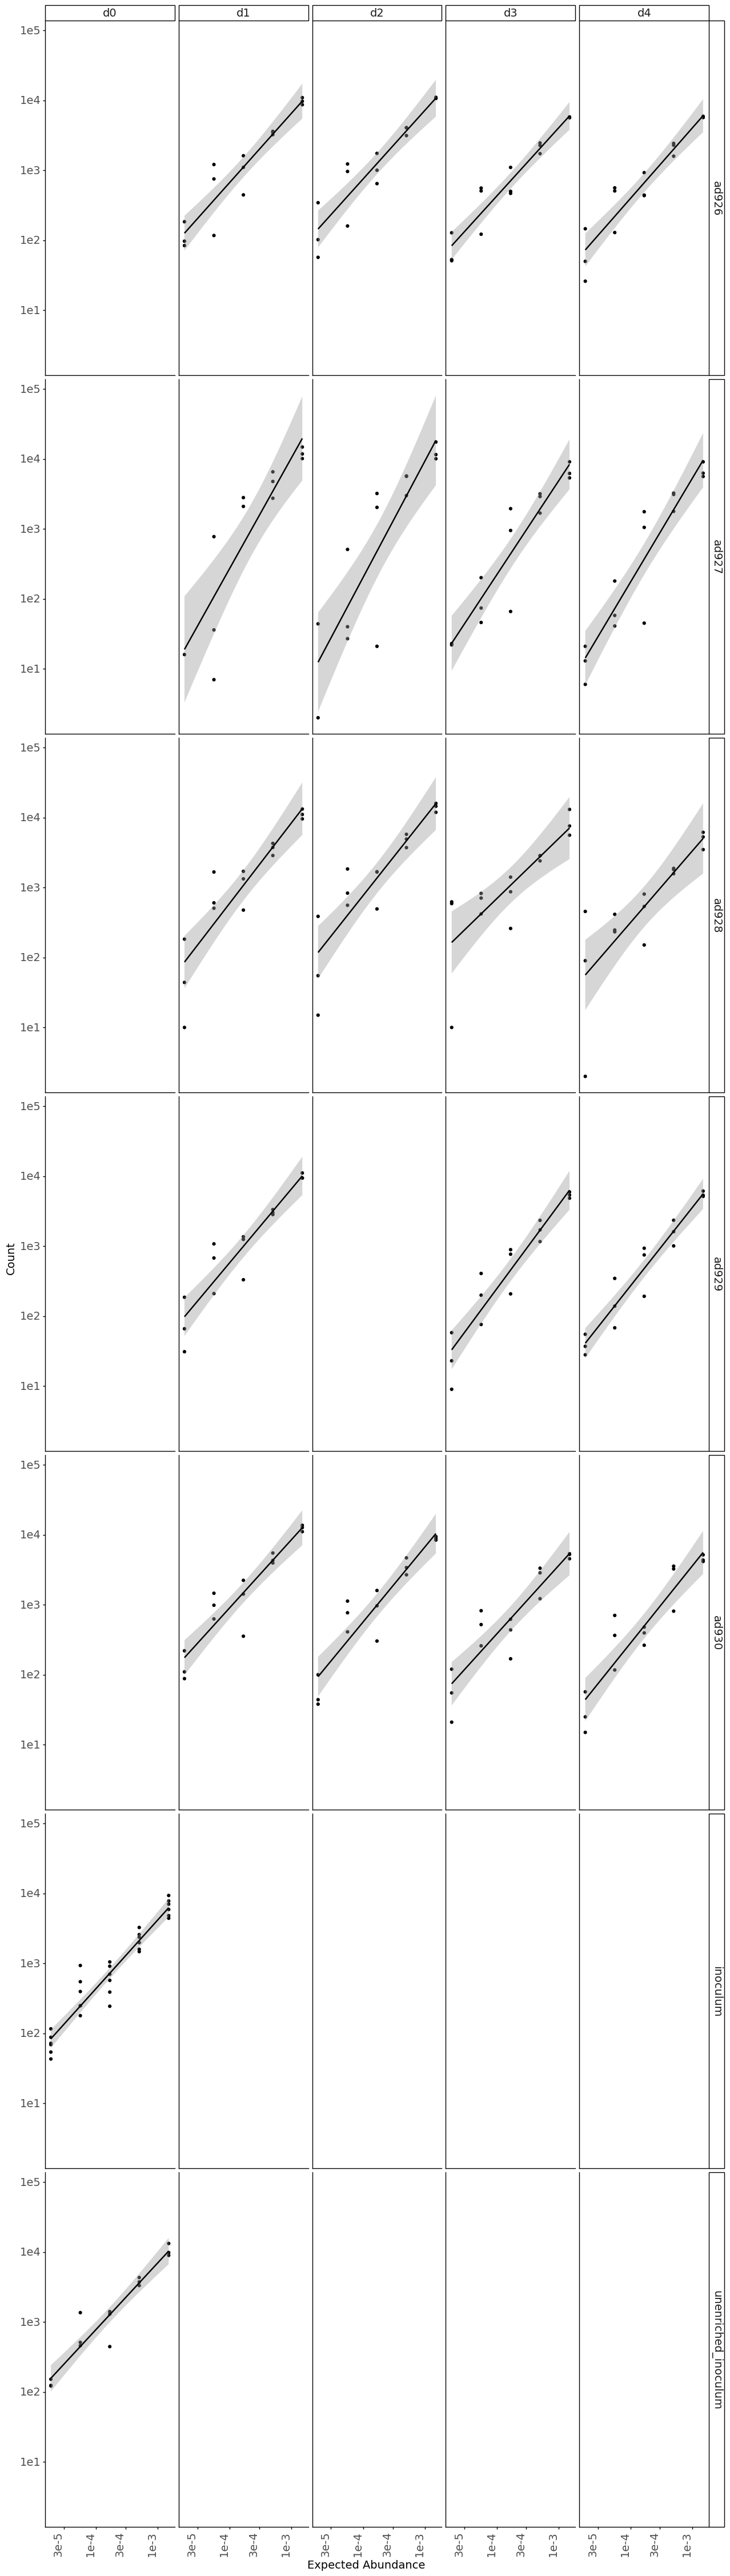

<ggplot: (-9223363265490542795)>

In [534]:
data = lib10_wt[lib10_wt.experiment =='TV4592A']
x = lib10_wt.day.nunique()
y = lib10_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*3)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

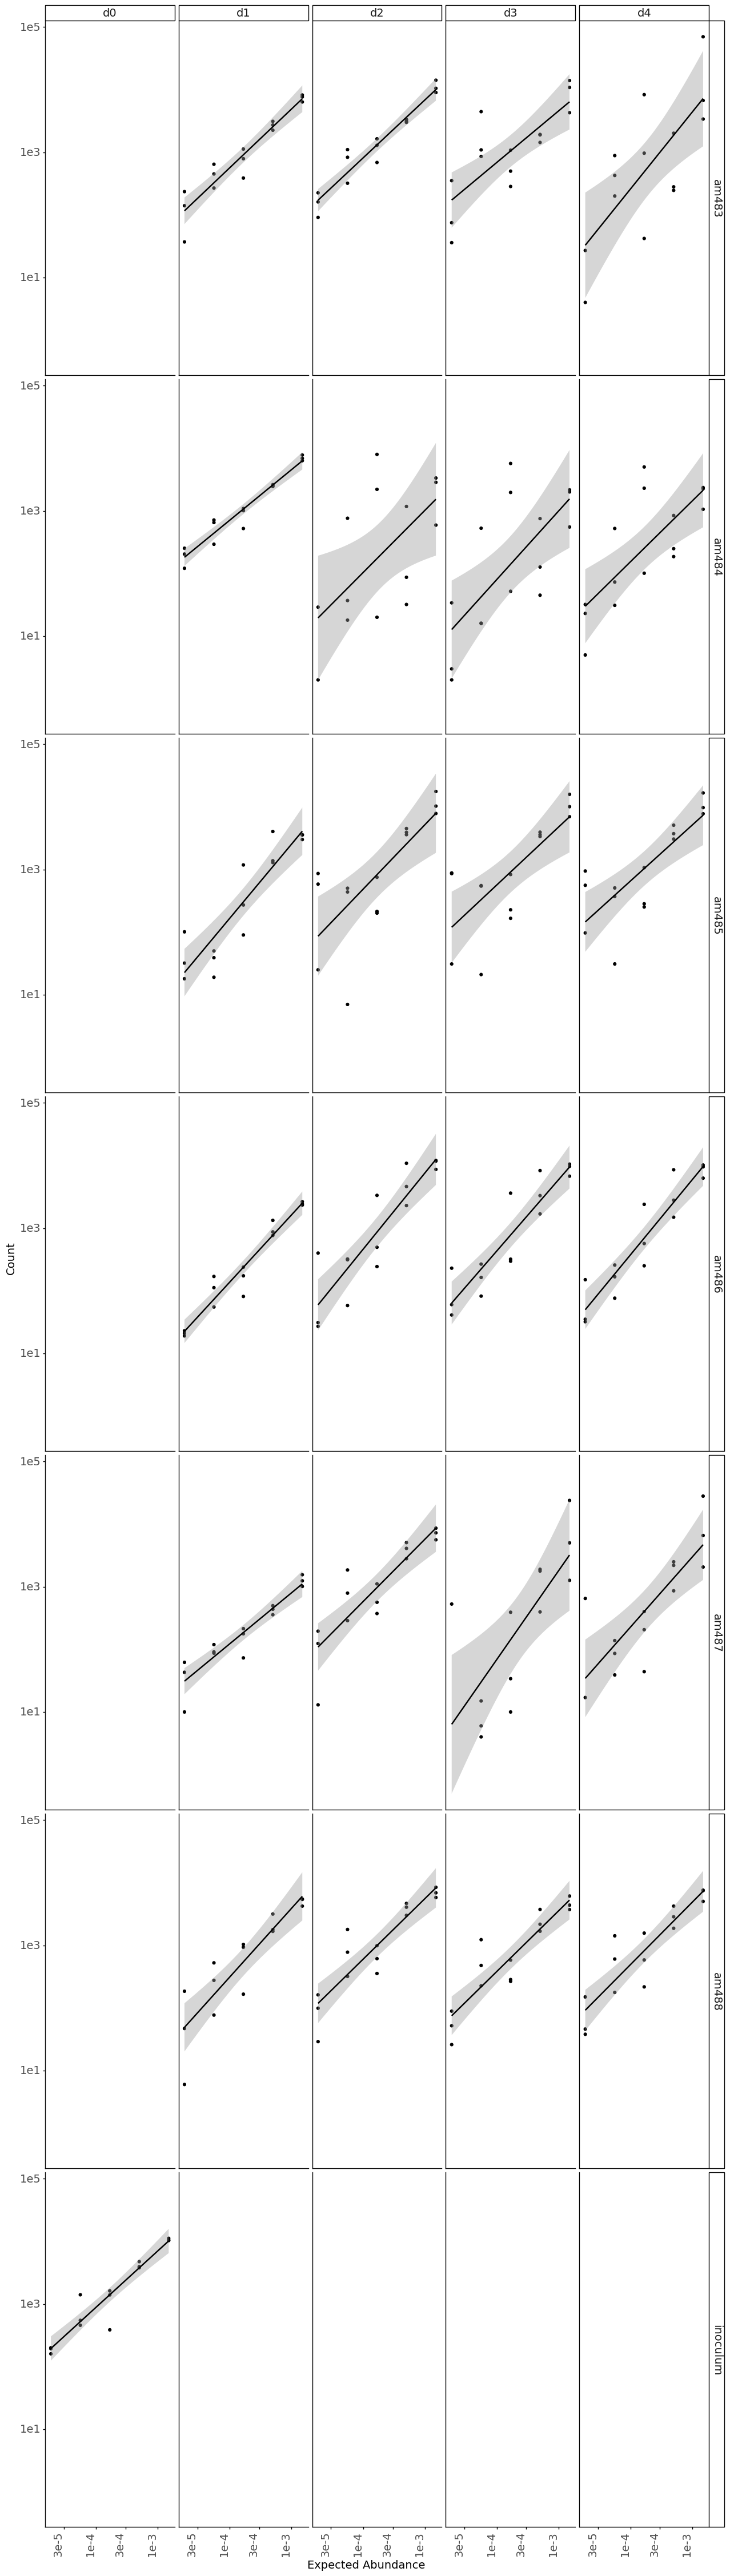

<ggplot: (-9223363265519707360)>

In [535]:
data = lib10_wt[lib10_wt.experiment =='TV5563A']
x = lib10_wt.day.nunique()
y = lib10_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*3)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

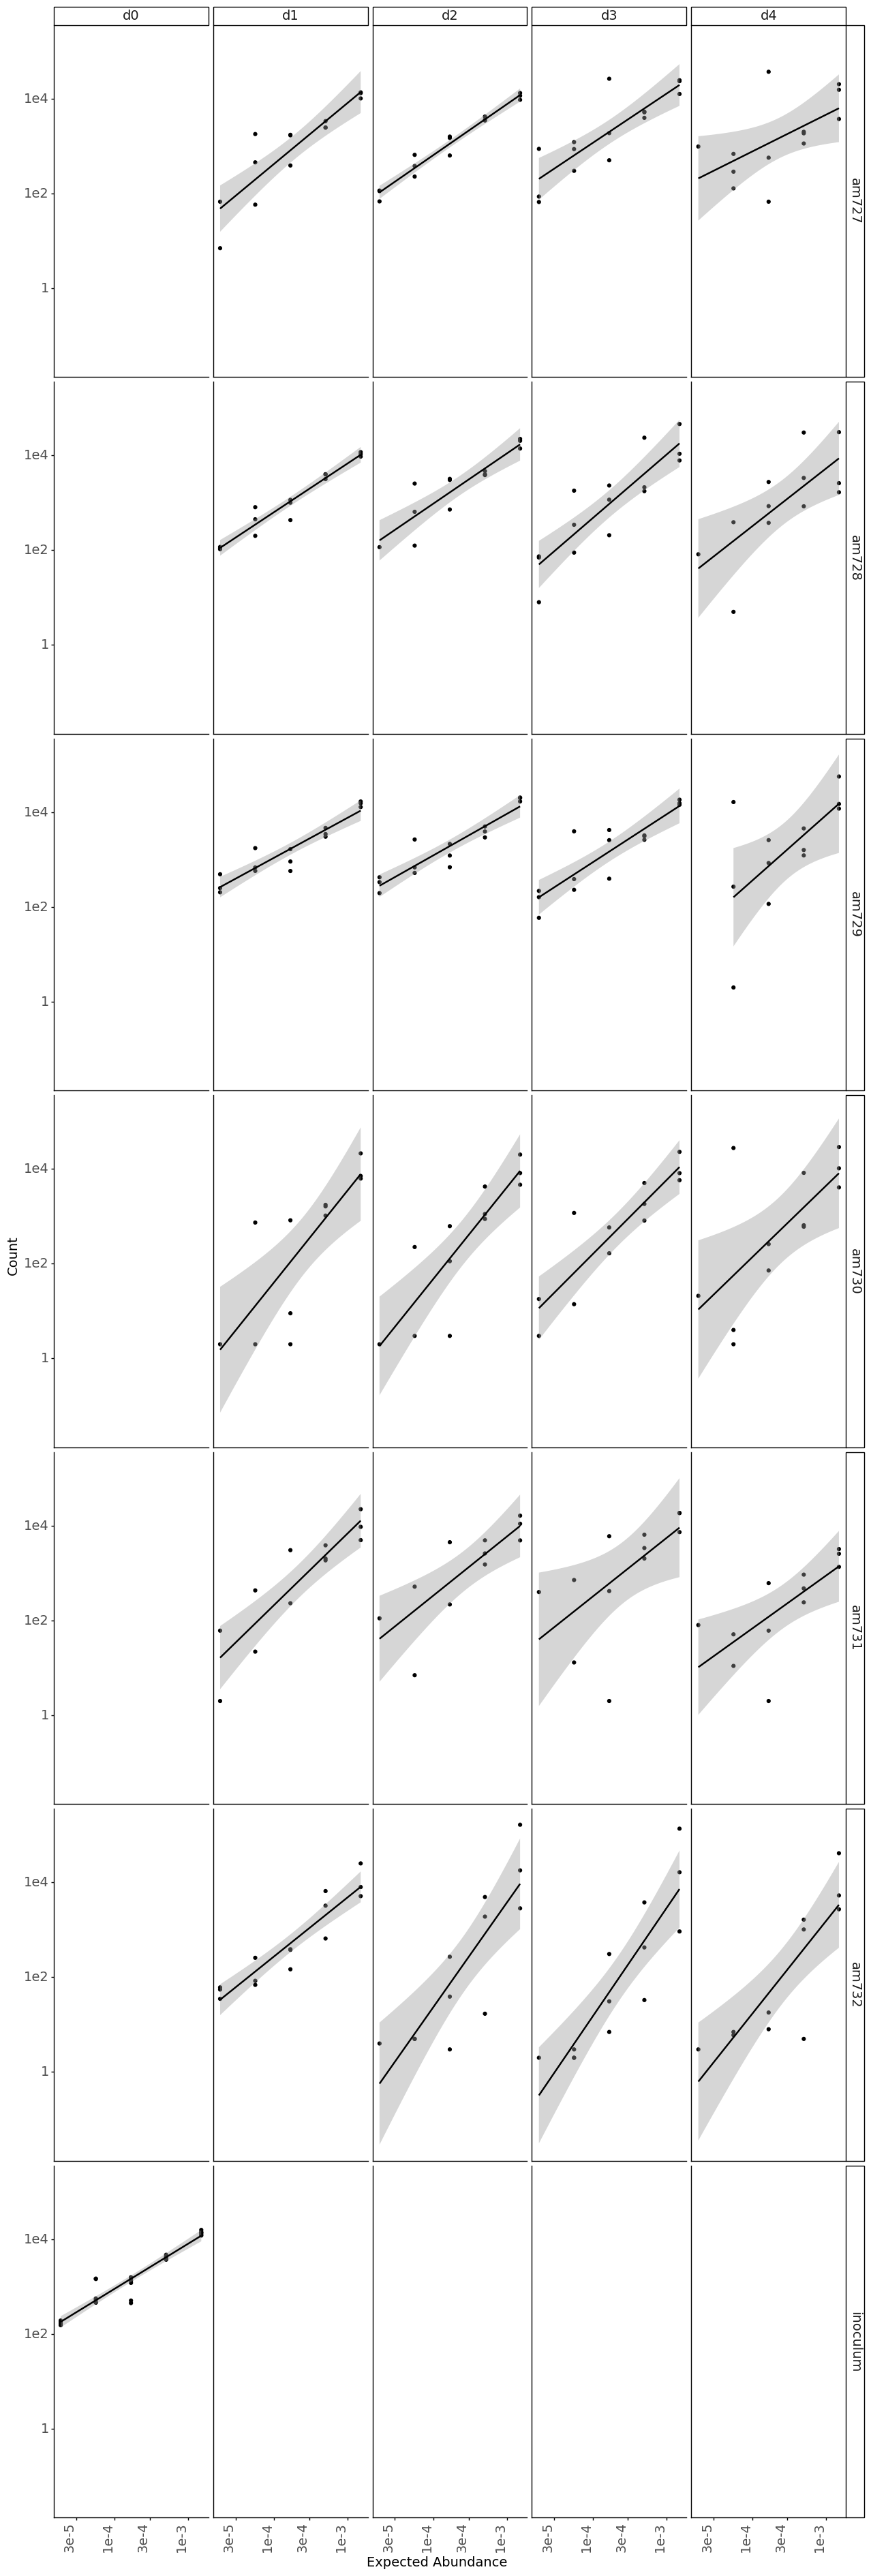

<ggplot: (-9223363265502473812)>

In [538]:
data = lib10_wt[lib10_wt.experiment =='TV5585A']
x = lib10_wt.day.nunique()
y = lib10_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*2.5)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

# Library 14_2

In [280]:
lib14_cnt = cnt_df[cnt_df.library == 'library_14_2'].copy()
lib14_cnt = lib14_cnt[['barcode', 'sampleID', 'experiment', 'mouse', 'day', 'tissue', 'dnaid', 'cnt']].drop_duplicates()
lib14_cnt['sampleID'] = lib14_cnt['sampleID']+ "_" + lib14_cnt['dnaid'] + '_' + lib14_cnt['experiment']
lib14_sdata = lib14_cnt[['sampleID', 'mouse', 'day', 'tissue', 'dnaid', 'experiment']].set_index('sampleID').drop_duplicates()
lib14_cnt = lib14_cnt.pivot(index='barcode', columns='sampleID', values='cnt')
lib14_cnt = lib14_cnt.fillna(0)
columns_to_filter = [f for f in lib14_cnt.columns if 'inoculum' in f]
lib14_cnt = lib14_cnt[(lib14_cnt[columns_to_filter] >= 1000).all(1)]

## VST Normalized Data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


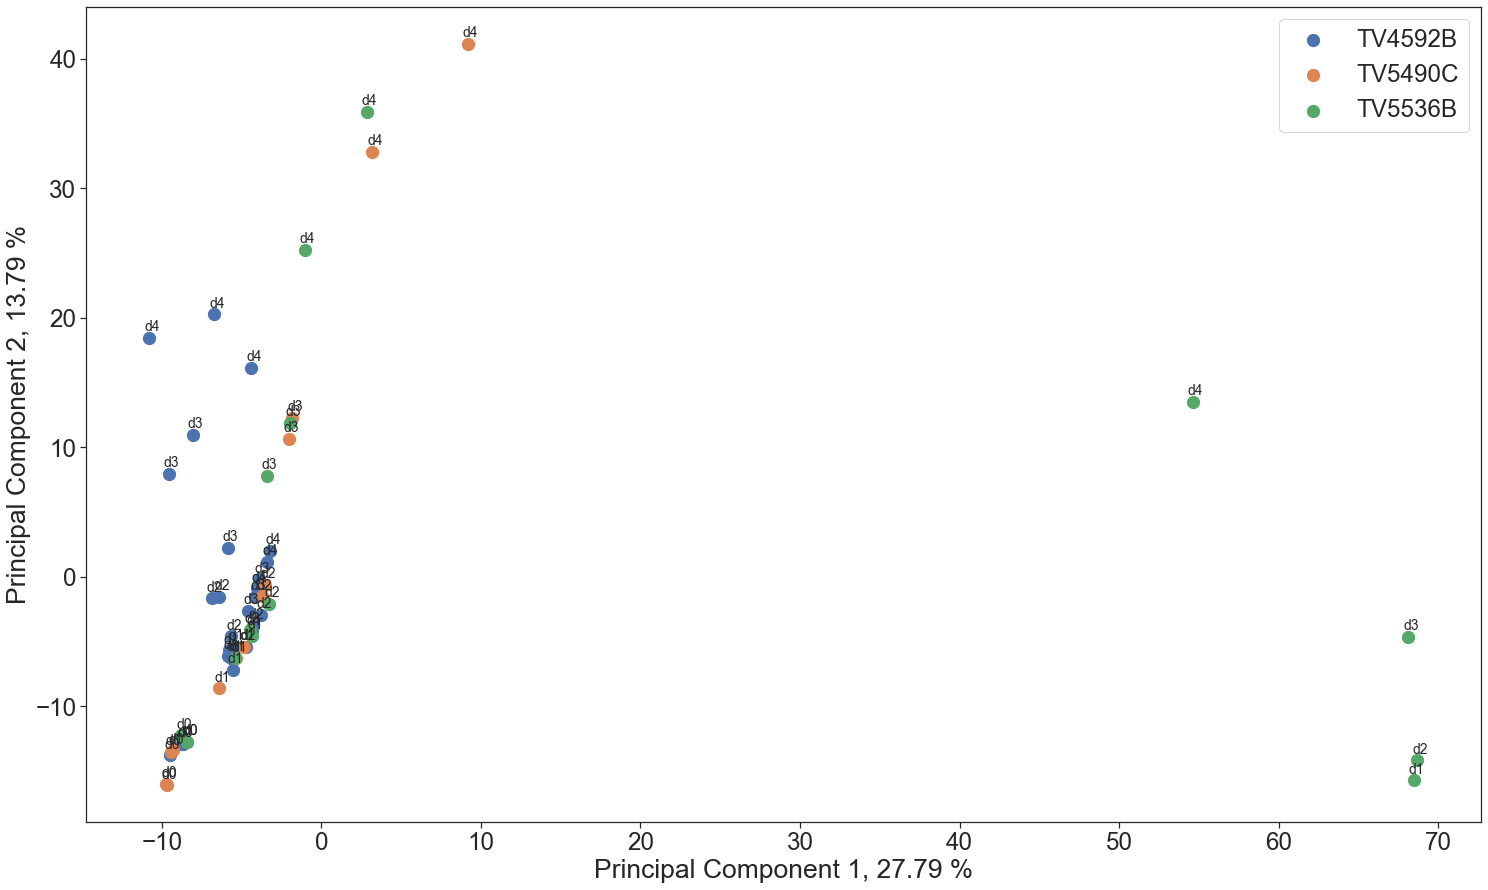

In [287]:
sdf14 = lib14_sdata
edf14 = lib14_cnt[list(sdf14.index)]
sdf14.to_csv(Path(root)/results/'lib14_sdf.csv')
edf14.to_csv(Path(root)/results/'lib14_edf.csv')
# Run DESeq2
lib14_vst = pd.read_csv(Path(root)/results/'lib14_vsd.csv').rename({'Unnamed: 0':'barcode'}, axis=1).set_index('barcode')
pDf_vst, pc1_vst, pc2_vst = find_pc1_pc2(lib14_vst, lib14_sdata)

plotPCA(pDf_vst, pc1_vst, pc2_vst, colorby='experiment', nameby='day', col=list(sns.color_palette()));

In [291]:
lib10_sdata.mouse.nunique()

19

## CLR Data Transformation

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


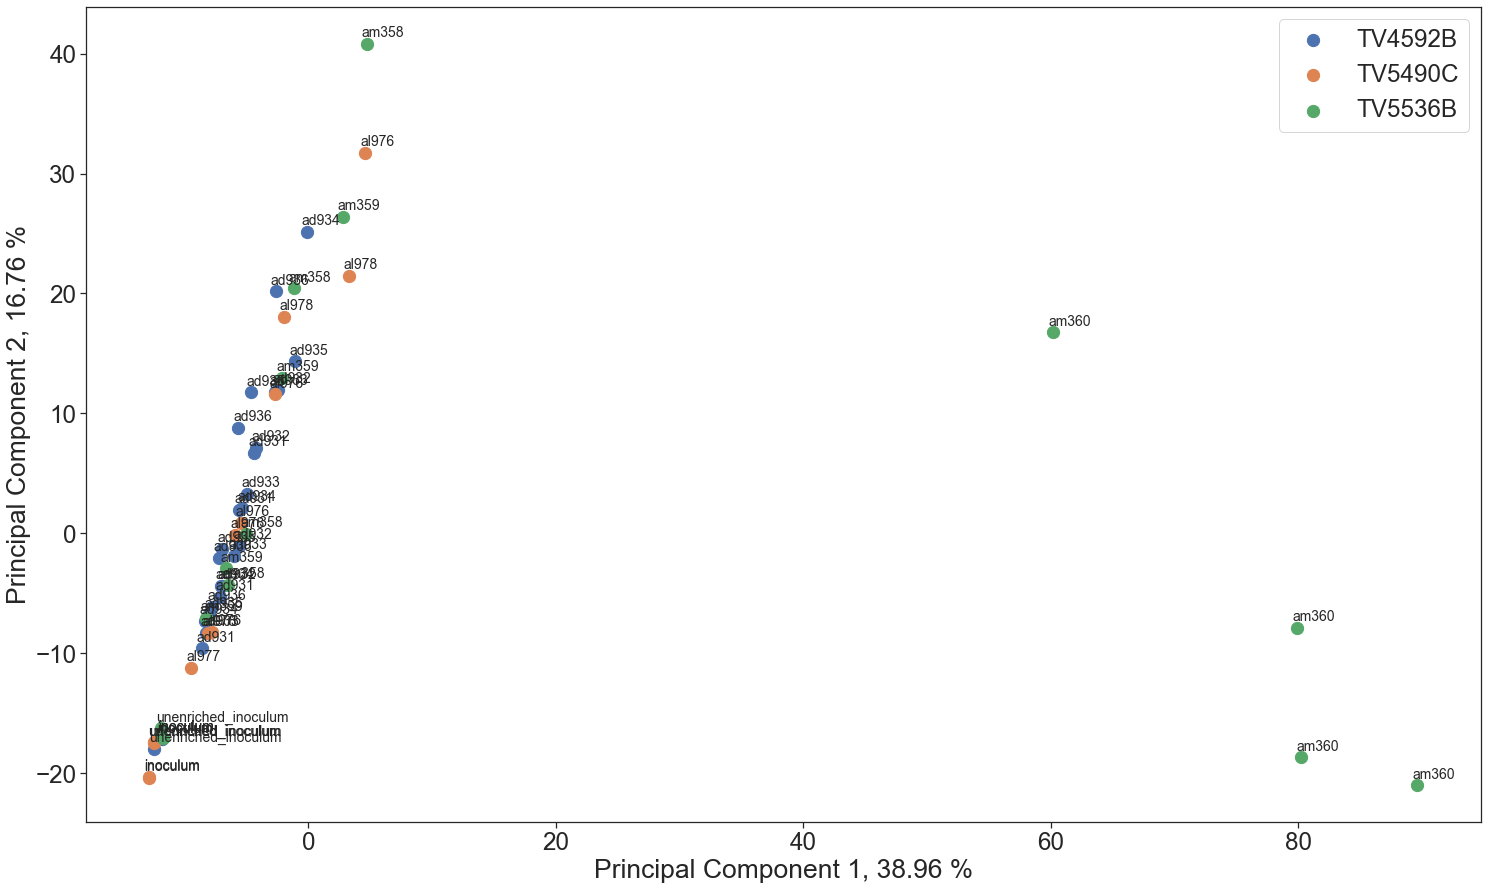

In [298]:
import numpy as np
from skbio.stats.composition import clr
lib14_clr = lib14_cnt.apply(lambda x: clr(x+1))

pDf_clr, pc1_clr, pc2_clr = find_pc1_pc2(lib14_clr, lib14_sdata)

plotPCA(pDf_clr, pc1_clr, pc2_clr, colorby='experiment', nameby='mouse', col=list(sns.color_palette()));

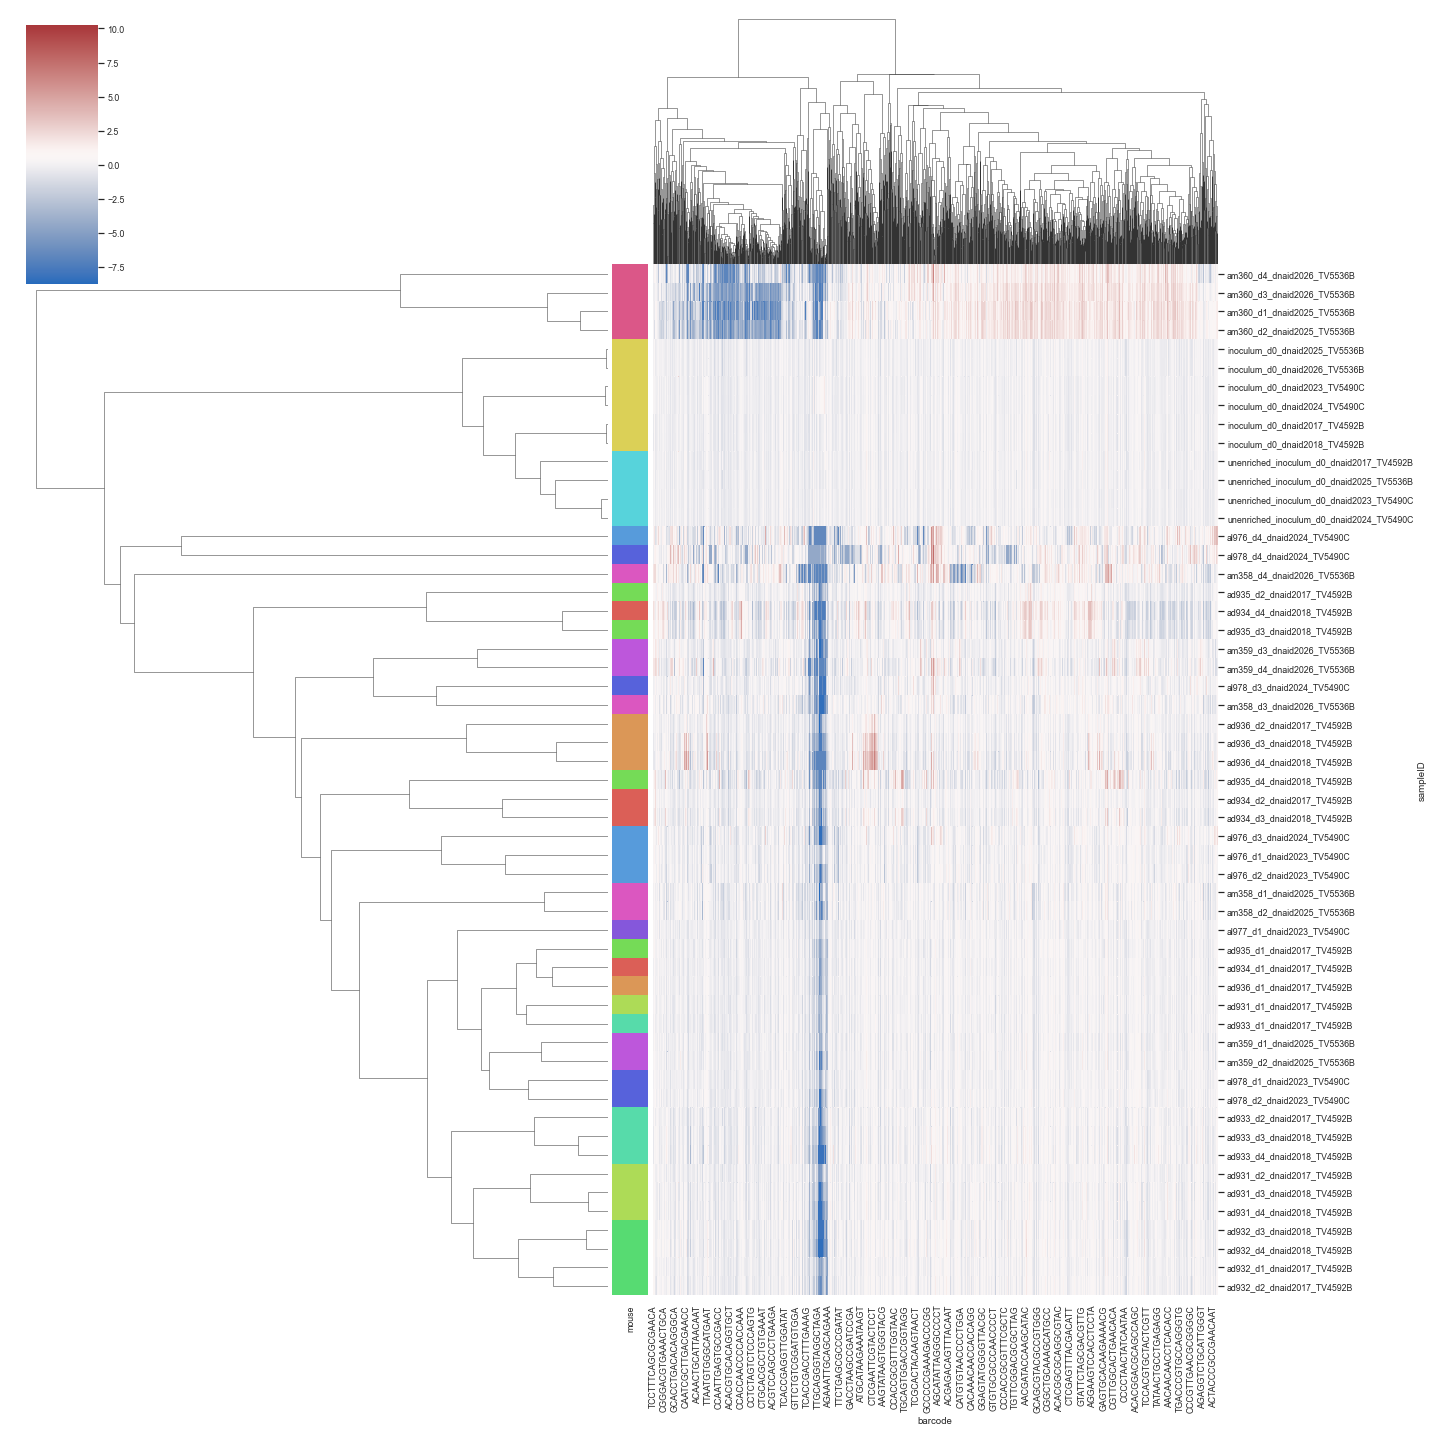

In [300]:
sns.set(font_scale=.8)
lut = dict(zip(lib14_sdata.mouse.unique(), sns.color_palette("hls", 14)))
row_colors = lib14_sdata.mouse.map(lut)

sns.clustermap(lib14_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap='vlag')

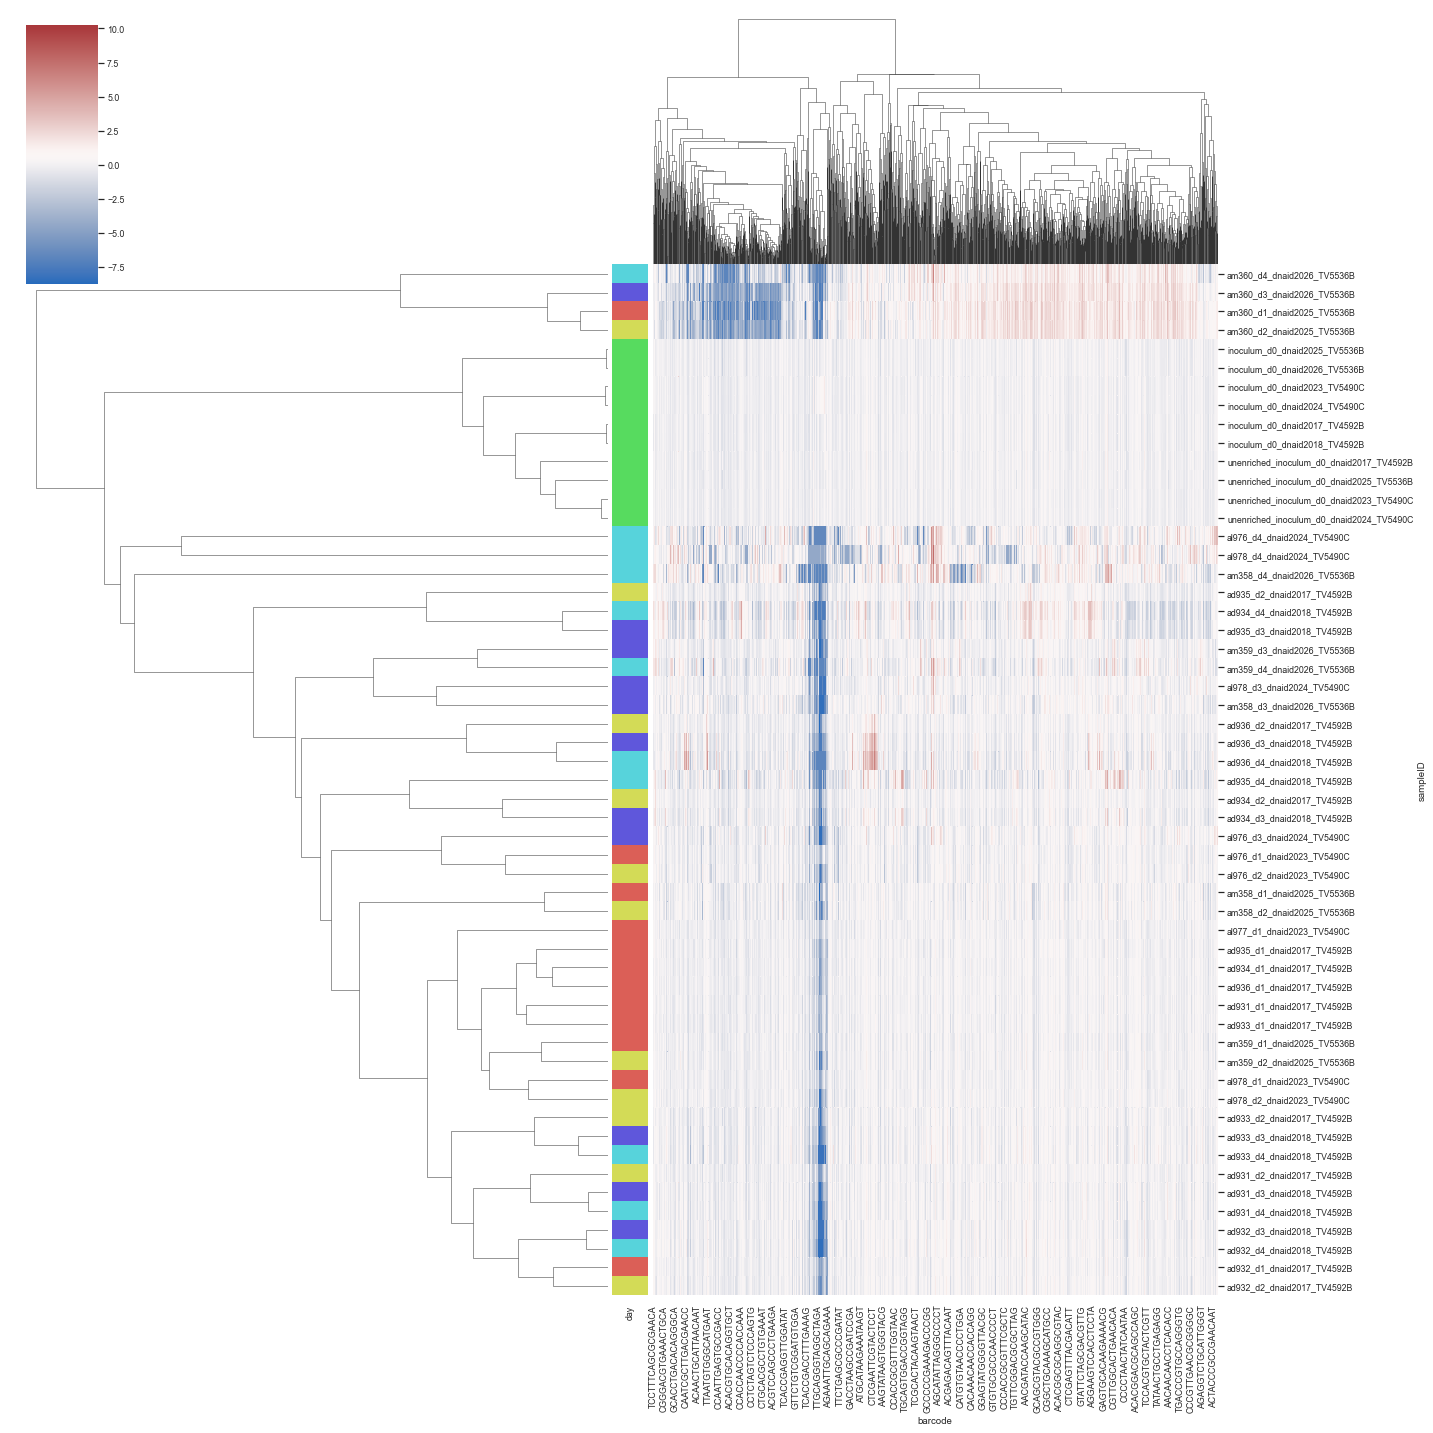

In [301]:
sns.set(font_scale=.8)
lut = dict(zip(lib14_sdata.day.unique(), sns.color_palette("hls", 6)))
row_colors = lib14_sdata.day.map(lut)

sns.clustermap(lib14_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap='vlag')

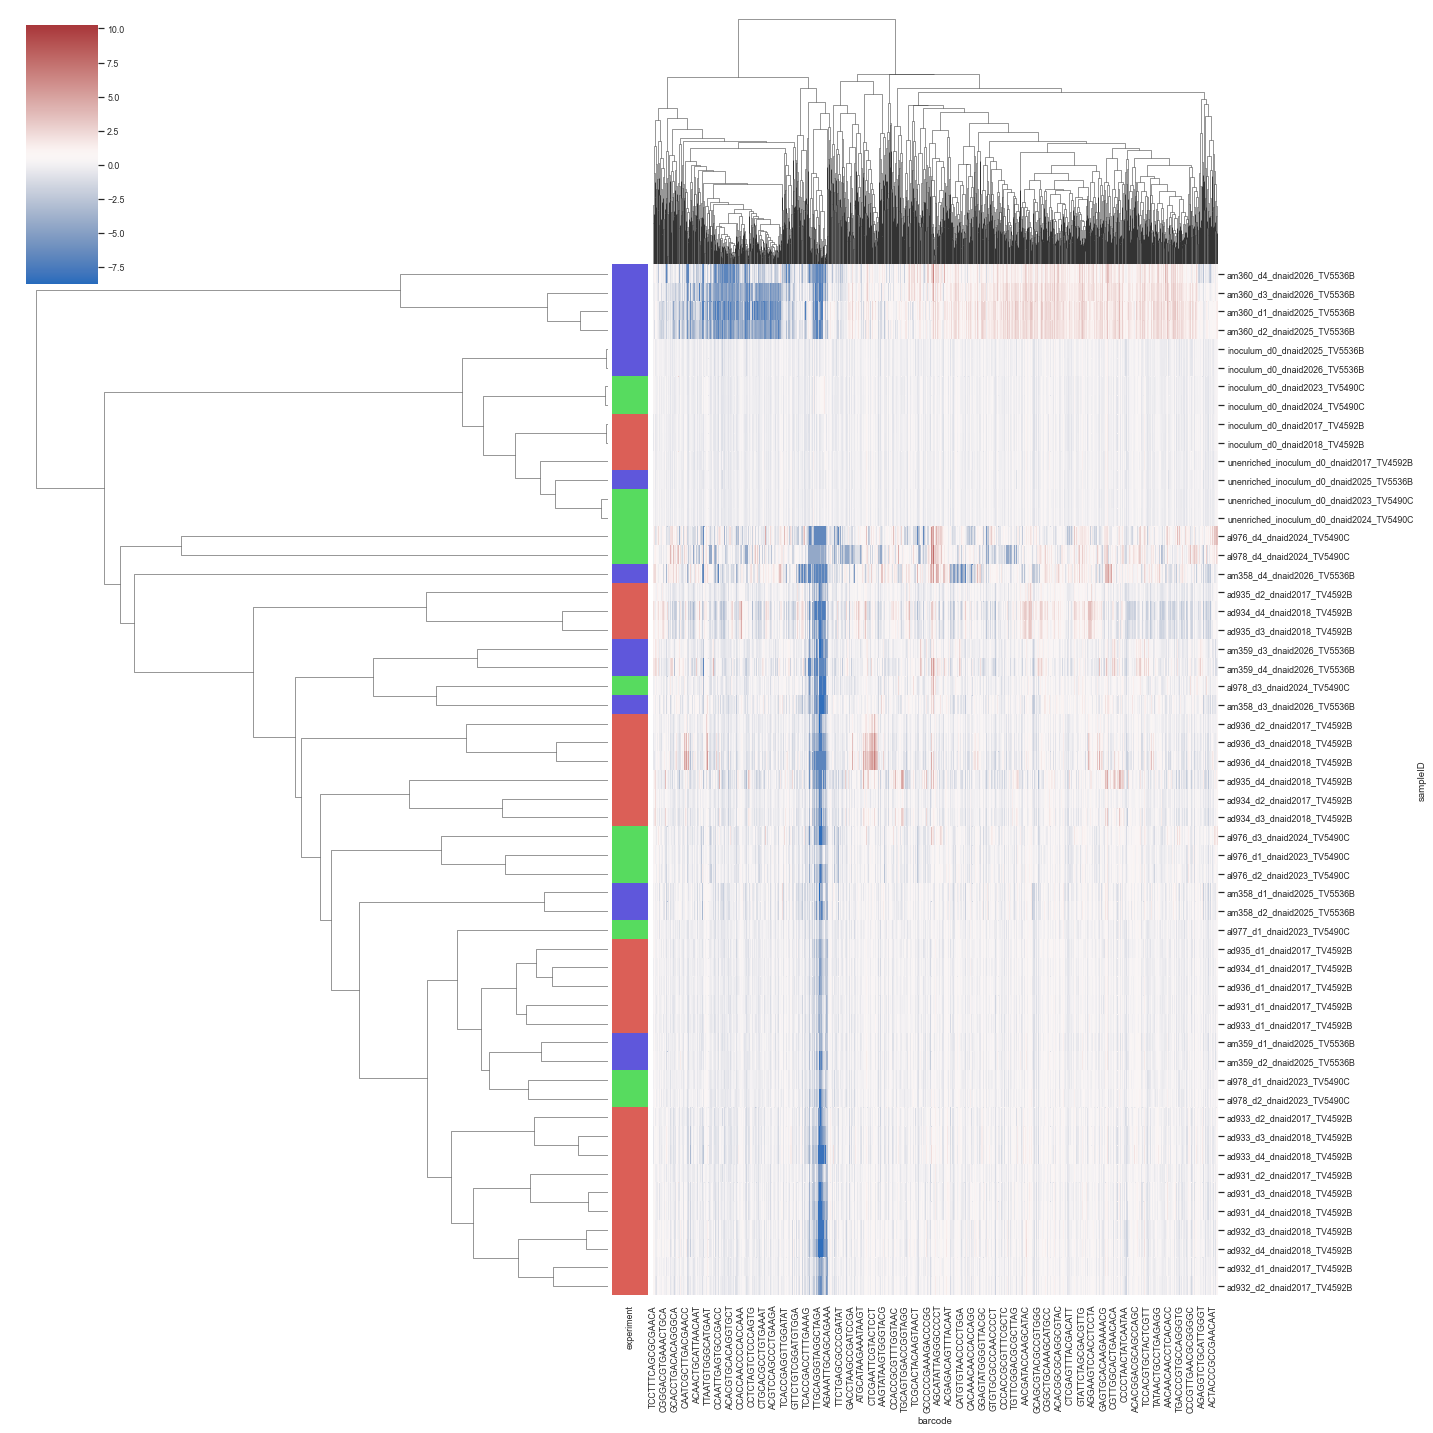

In [302]:
sns.set(font_scale=.8)
lut = dict(zip(lib14_sdata.experiment.unique(), sns.color_palette("hls", 3)))
row_colors = lib14_sdata.experiment.map(lut)

sns.clustermap(lib14_clr.T, method='average', metric='correlation', figsize=(20, 20), 
               row_colors=row_colors, dendrogram_ratio=(0.5,0.2), cmap='vlag')

In [426]:
lib14_wt = (cnt_df[(cnt_df.phenotype == 'wt')&(cnt_df.library == 'library_14_2')]
            .copy()[['barcode','cnt', 'conc', 'sampleName', 'experiment', 'dnaid', 'sampleID', 'day', 'mouse']])

lib14_wt['logcnt'] = np.log2(lib14_wt['cnt'])
corr_df = lib14_wt.groupby(['experiment','sampleID'])[['conc', 'logcnt']].corr().reset_index()
corr_df = corr_df[corr_df['level_2'] == 'conc'].drop(['level_2', 'conc'], axis=1)
corr_df.columns = ['experiment','sampleID', 'R']
corr_df['Rlab'] = corr_df.R.apply(lambda x: f'R = {round(x, 2)}')
lib14_wt = lib14_wt.merge(corr_df, on=['experiment', 'sampleID'])

lib14_wt.experiment.unique()

array(['TV4592B', 'TV5490C', 'TV5536B'], dtype=object)

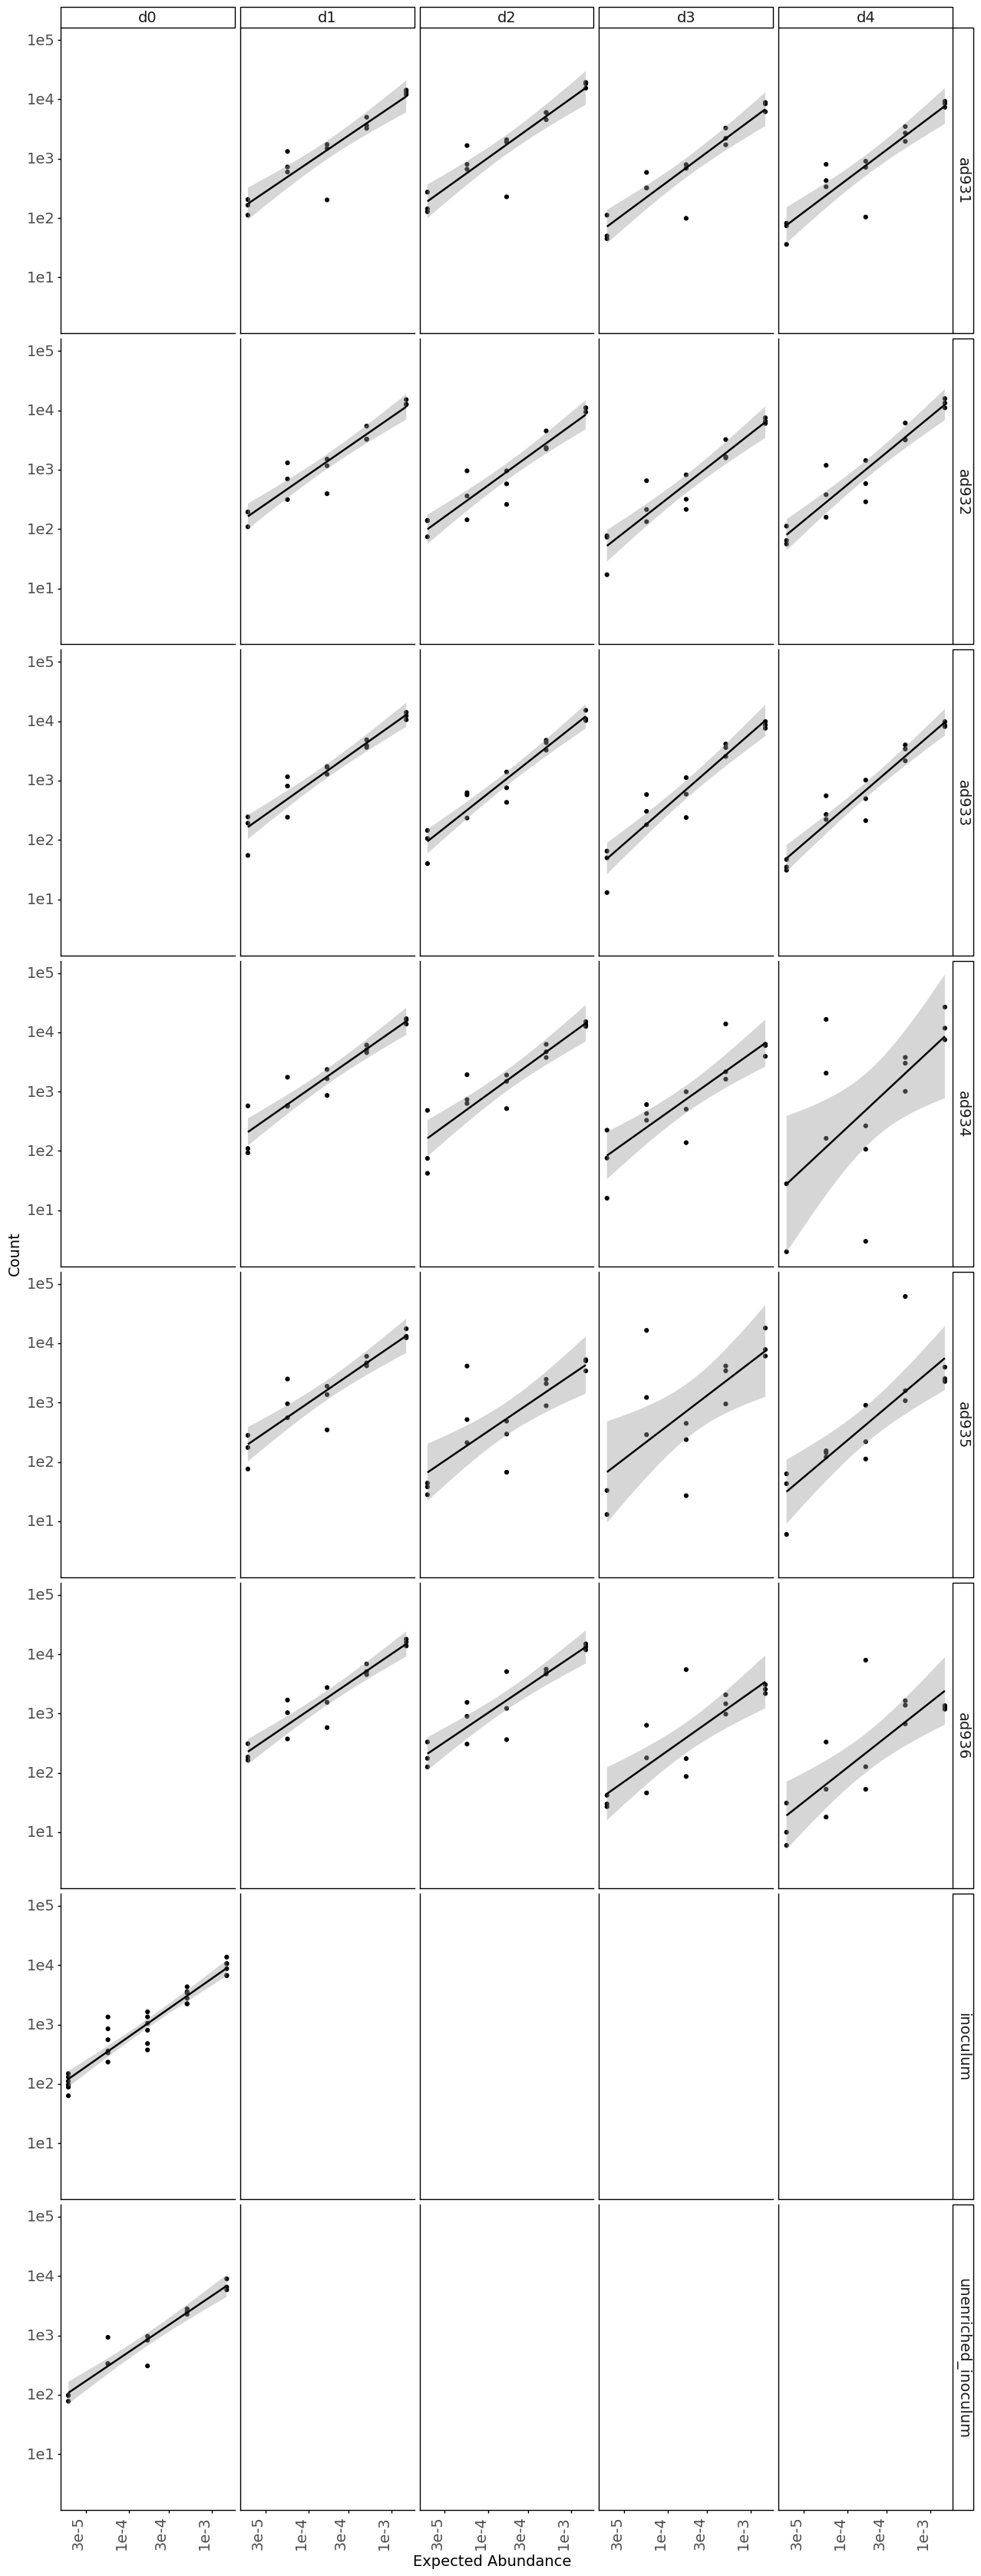

<ggplot: (8771372907875)>

In [431]:
data = lib14_wt[lib14_wt.experiment =='TV4592B']
x = lib14_wt.day.nunique()
y = lib14_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*3)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

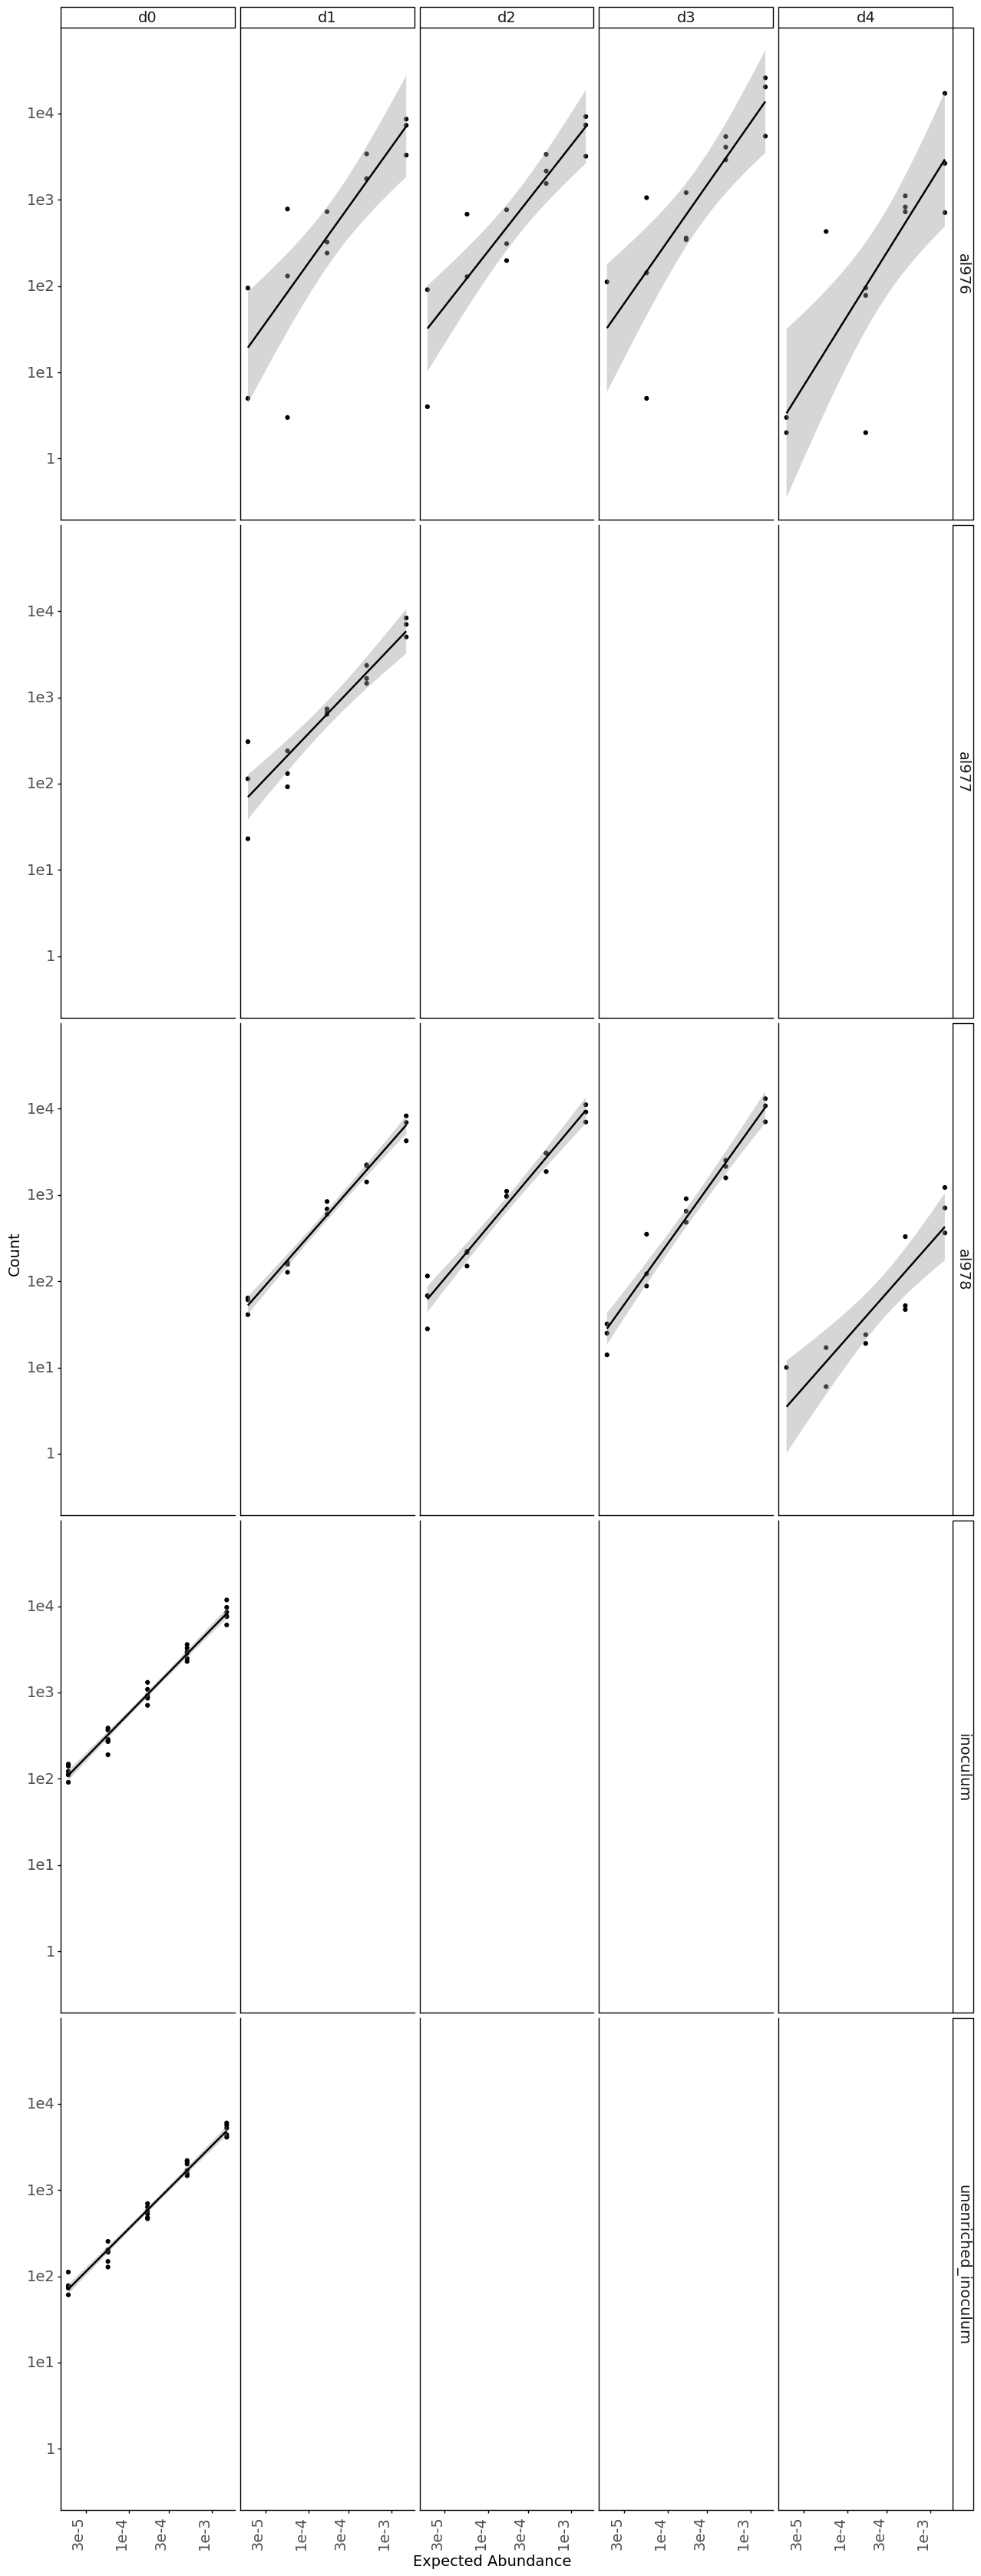

<ggplot: (8771372178205)>

In [435]:
data = lib14_wt[lib14_wt.experiment =='TV5490C']
x = lib14_wt.day.nunique()
y = lib14_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*3)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

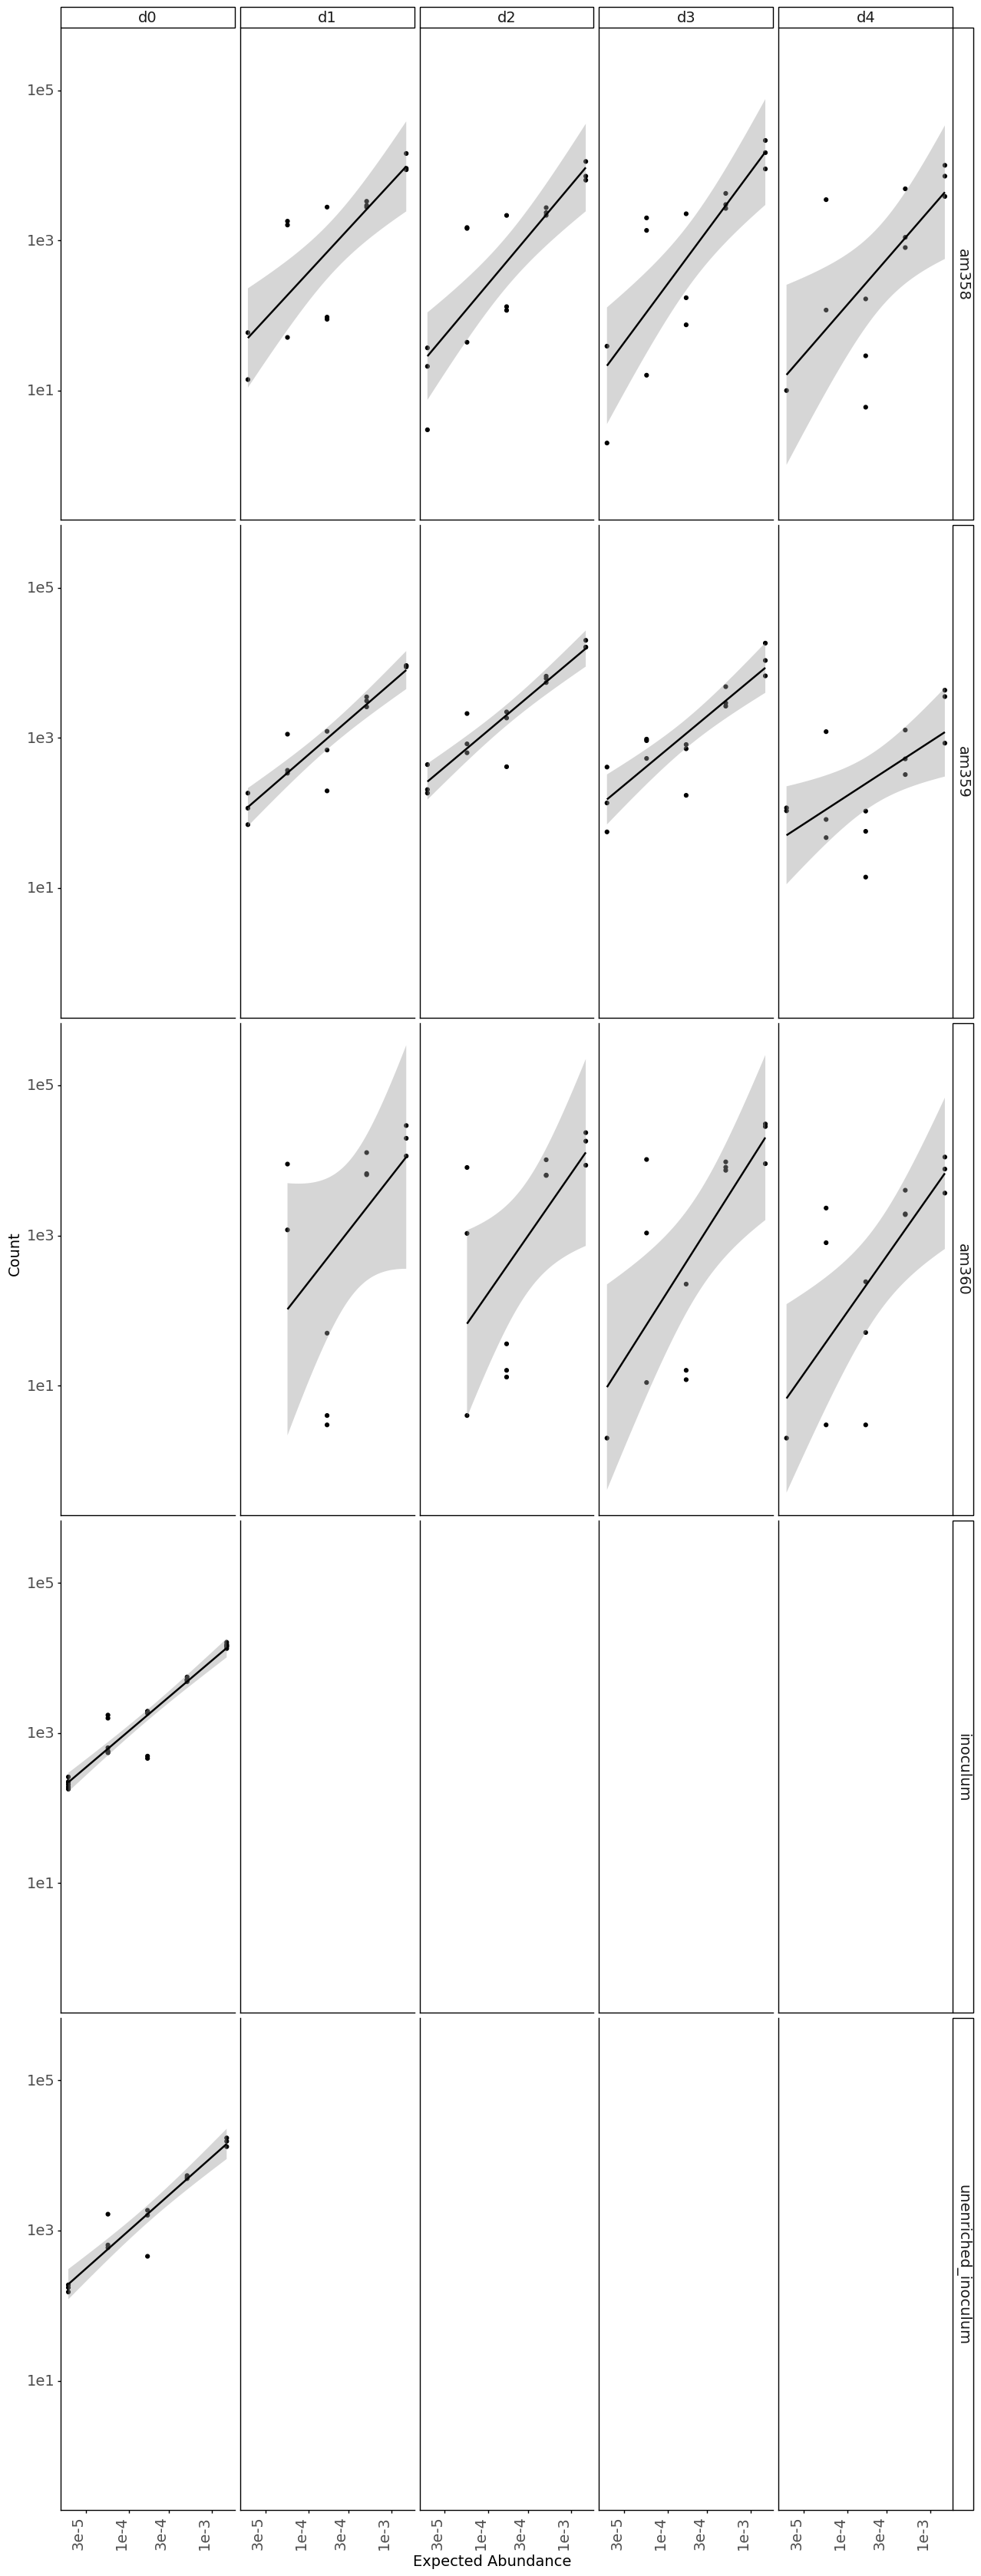

<ggplot: (8771367594574)>

In [436]:
data = lib14_wt[lib14_wt.experiment =='TV5536B']
x = lib14_wt.day.nunique()
y = lib14_wt.mouse.nunique()
p9.options.figure_size = (x*3, y*3)
g = (p9.ggplot(data, p9.aes(x='conc', y='cnt'))
  + p9.geom_point()
  + p9.geom_smooth(method="lm")
  + p9.theme_classic()
  + p9.theme(text=p9.element_text(size=14),
             axis_text_x=p9.element_text(rotation=90, hjust=1))
    #+ p9.geom_text(p9.aes(label='Rlab', x=0.0001, y=.1))
  + p9.ylab("Count")
  + p9.xlab("Expected Abundance")
  + p9.scale_y_log10()
  + p9.scale_x_log10()
  + p9.facet_grid('mouse~day'))
g

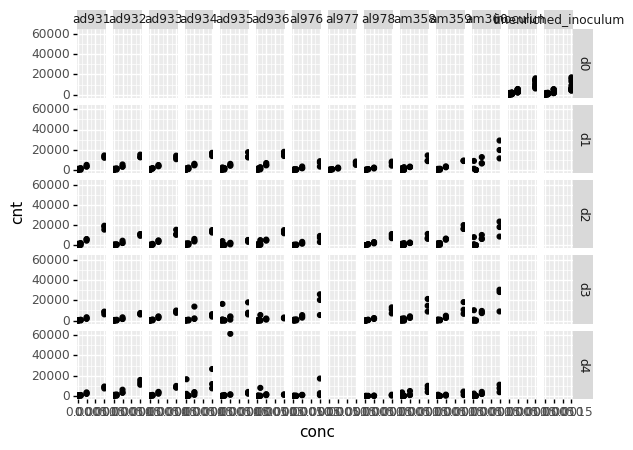

<ggplot: (8771566852686)>

In [396]:
(p9.ggplot(p9.aes(x='conc', y='cnt', ),data=lib14_wt)
+ p9.geom_point()
+p9.facet_grid('day ~ mouse'))

In [304]:
lib14_cnt.sample(5)

sampleID           ad931_d1_dnaid2017_TV4592B  ad931_d2_dnaid2017_TV4592B  \
barcode                                                                     
ACTCCCACGCTGACAAA                      7816.0                      8892.0   
CAATCGCTTGACGAACC                      6401.0                      6440.0   
GACCAAAGATAACGTTA                      5020.0                      6105.0   
GTAGTAACTTATAGTTC                      7143.0                     10684.0   
TACGGCGCAGCATATAC                      5667.0                      6885.0   

sampleID           ad931_d3_dnaid2018_TV4592B  ad931_d4_dnaid2018_TV4592B  \
barcode                                                                     
ACTCCCACGCTGACAAA                      6305.0                      6398.0   
CAATCGCTTGACGAACC                      5826.0                      7423.0   
GACCAAAGATAACGTTA                      4520.0                      4251.0   
GTAGTAACTTATAGTTC                      6815.0                      7882.0   
TACGGCGCAGCATATAC                      5474.0                      5419.0   

sampleID           ad932_d1_dnaid2017_TV4592B  ad932_d2_dnaid2017_TV4592B  \
barcode                                                                     
ACTCCCACGCTGACAAA                     15728.0                      8665.0   
CAATCGCTTGACGAACC                      9575.0                      4254.0   
GACCAAAGATAACGTTA                      5760.0                      4114.0   
GTAGTAACTTATAGTTC                      7004.0                      5967.0   
TACGGCGCAGCATATAC                      8844.0                      4854.0   

sampleID           ad932_d3_dnaid2018_TV4592B  ad932_d4_dnaid2018_TV4592B  \
barcode                                                                     
ACTCCCACGCTGACAAA                     10530.0                     14211.0   
CAATCGCTTGACGAACC                      5489.0                      9392.0   
GACCAAAGATAACGTTA                      4085.0                      5335.0   
GTAGTAACTTATAGTTC                      4901.0                      8897.0   
TACGGCGCAGCATATAC                      5470.0                      7331.0   

sampleID           ad933_d1_dnaid2017_TV4592B  ad933_d2_dnaid2017_TV4592B  \
barcode                                                                     
ACTCCCACGCTGACAAA                     11208.0                      8599.0   
CAATCGCTTGACGAACC                      5577.0                      4088.0   
GACCAAAGATAACGTTA                      5199.0                      5261.0   
GTAGTAACTTATAGTTC                      7290.0                      6935.0   
TACGGCGCAGCATATAC                      5549.0                      4228.0   

sampleID           ...  inoculum_d0_dnaid2017_TV4592B  \
barcode            ...                                  
ACTCCCACGCTGACAAA  ...                        12580.0   
CAATCGCTTGACGAACC  ...                        11037.0   
GACCAAAGATAACGTTA  ...                         6048.0   
GTAGTAACTTATAGTTC  ...                         5812.0   
TACGGCGCAGCATATAC  ...                         8761.0   

sampleID           inoculum_d0_dnaid2018_TV4592B  \
barcode                                            
ACTCCCACGCTGACAAA                         7953.0   
CAATCGCTTGACGAACC                         6902.0   
GACCAAAGATAACGTTA                         3867.0   
GTAGTAACTTATAGTTC                         3572.0   
TACGGCGCAGCATATAC                         5617.0   

sampleID           inoculum_d0_dnaid2023_TV5490C  \
barcode                                            
ACTCCCACGCTGACAAA                         6485.0   
CAATCGCTTGACGAACC                         4313.0   
GACCAAAGATAACGTTA                         2731.0   
GTAGTAACTTATAGTTC                         3489.0   
TACGGCGCAGCATATAC                         4737.0   

sampleID           inoculum_d0_dnaid2024_TV5490C  \
barcode                                            
ACTCCCACGCTGACAAA                         8557.0   
CAATCGCTTGACGA

### Steps
- Get genes that are present in all inoculum samples. 
    - Nubmer of samples is 10, choose genes that have sampleName.nunique == 10
- For each gene, if # of barcodes > 1, 
    - pick barcode that is present in all samples
    - pick a barcode with max count

In [337]:
# Steps

test = cnt_df[cnt_df.library == 'library_14_2']
test = test[test.day == 'd0']
test.sampleName.nunique()

10

In [349]:
t2 = test.groupby(['ShortName']).agg({'sampleName':['nunique']}).reset_index()
t2.columns = ['gene', 'num_samples']
t2 = t2[t2.num_samples == 10].gene.values
test = test[test.ShortName.isin(t2)]

barcode     cnt    ShortName    sampleName experiment  \
27258  ACTGCATCAAACCAACT  3759.0         aroE  dnaid2024_10    TV5490C   
12164  ACAAGGAATTGGGACAT  2938.0         fdnG  dnaid2023_10    TV5490C   
11983  TCGCTCGGAACCATCAA  9885.0         hslV  dnaid2026_10    TV5536B   
5842   AACAGATAACGACCTAA  8621.0         yhjS  dnaid2017_60    TV4592B   
13825  GTCTTGCATCAGCGCCA   306.0  SL1344_0544  dnaid2023_10    TV5490C   
76995  ACGAACCCTTACGTTAG  1338.0  SL1344_2535   dnaid2024_6    TV5490C   
84329  CCAGTGAAAAGCCCGTC  2845.0  SL1344_4051   dnaid2023_6    TV5490C   
83851  ACGATACATAACCCCTT   486.0         ssaK   dnaid2023_6    TV5490C   
37294  AACAAGTGTTCTCGGGT  3119.0         fdnG  dnaid2018_60    TV4592B   
5831   AAATCTTCCGATTCCCG  6347.0  SL1344_0033  dnaid2017_60    TV4592B   

                     sampleID      dnaid  
27258             inoculum_d0  dnaid2024  
12164             inoculum_d0  dnaid2023  
11983             inoculum_d0  dnaid2026  
5842              inoculum_d0  dnaid2017  
13825             inoculum_d0  dnaid2023  
76995  unenriched_inoculum_d0  dnaid2024  
84329  unenriched_inoculum_d0  dnaid2023  
83851  unenriched_inoculum_d0  dnaid2023  
37294             inoculum_d0  dnaid2018  
5831              inoculum_d0  dnaid2017

In [360]:
one_bc_per_gene = test.groupby('ShortName').barcode.nunique().reset_index()
m_bc_per_gene = one_bc_per_gene[one_bc_per_gene.barcode > 1].ShortName.values
one_bc_per_gene = one_bc_per_gene[one_bc_per_gene.barcode == 1].ShortName.values

In [362]:
len(m_bc_per_gene)

400

In [361]:
len(one_bc_per_gene)

816

In [363]:
test = test[test.ShortName.isin(m_bc_per_gene)]

In [364]:
test.sample(10)[['barcode', 'cnt', 'ShortName', 'sampleName', 'experiment', 'sampleID', 'dnaid']]

barcode     cnt       ShortName    sampleName experiment  \
18947  CCCTAACACCTCGCGAA  6866.0            ssaD   dnaid2025_6    TV5536B   
13674  GGATACATGAAACGACC  7451.0            rfaI  dnaid2023_10    TV5490C   
83700  AAGGCCTCGGAATAATC     6.0     SL1344_3663   dnaid2023_6    TV5490C   
6175   AGCAACCAGAGGAGGTA  9827.0     SL1344_3750  dnaid2017_60    TV4592B   
20493  AGACTGGACAGTAAACA  1196.0            rfbB  dnaid2025_10    TV5536B   
77067  ACTGCCCAGTTGACGCA  5855.0            yiaH   dnaid2024_6    TV5490C   
12008  AAATACCCCTAGACACC   107.0  SL1344_RS27455  dnaid2023_10    TV5490C   
37569  ACTGCAGTGACTAGGGG  4148.0     SL1344_3812  dnaid2018_60    TV4592B   
85516  TTGCAGGGTAGGCTAGA  2133.0            rfaB   dnaid2023_6    TV5490C   
85012  GGCCGAACCTCACCGGC  3525.0     SL1344_3514   dnaid2023_6    TV5490C   

                     sampleID      dnaid  
18947  unenriched_inoculum_d0  dnaid2025  
13674             inoculum_d0  dnaid2023  
83700  unenriched_inoculum_d0  dnaid2023  
6175              inoculum_d0  dnaid2017  
20493             inoculum_d0  dnaid2025  
77067  unenriched_inoculum_d0  dnaid2024  
12008             inoculum_d0  dnaid2023  
37569             inoculum_d0  dnaid2018  
85516  unenriched_inoculum_d0  dnaid2023  
85012  unenriched_inoculum_d0  dnaid2023

In [369]:
x = test.groupby(['ShortName', 'barcode']).sampleName.nunique().reset_index()
x = x[x.sampleName == 10].barcode.values

In [370]:
test = test[test.barcode.isin(x)]

In [376]:
test.groupby(['ShortName', 'barcode']).agg({'cnt':['median']})
# pick the one with the largest mean

cnt
                               median
ShortName   barcode                  
IsrA        GAAATGTCAAGAGGAGC  1663.5
SL1344_0014 ACACTCATTATCACTGG  5403.0
            CGAGCAAATCAGCACAA  2808.5
SL1344_0017 CCGAGACCGCAAAGCCT  4407.5
            CGATACCGTTAATAATT  1268.0
...                               ...
yqjF        ATAACGATGCCACTCTG  4396.5
ytfL        GAGACTTGCCTAGGGTA  5131.0
            TGAAAACCCTTCCGAAT  2231.0
zraP        ACACGTGCACAGGTGCT  3503.5
            TCTGTGAGCGGTACCCT  3390.0

[1111 rows x 1 columns]

In [372]:
test[test.ShortName == 'ytfL']

barcode     cnt  libcnt     sstart      sseqid sstrand  \
6975   GAGACTTGCCTAGGGTA  7633.0  2271.0  4665584.0  FQ312003.1    plus   
7568   TGAAAACCCTTCCGAAT  3427.0   871.0  4665257.0  FQ312003.1    plus   
54929  GAGACTTGCCTAGGGTA  3825.0  2271.0  4665584.0  FQ312003.1    plus   
55522  TGAAAACCCTTCCGAAT  1637.0   871.0  4665257.0  FQ312003.1    plus   
38429  GAGACTTGCCTAGGGTA  4884.0  2271.0  4665584.0  FQ312003.1    plus   
39022  TGAAAACCCTTCCGAAT  2172.0   871.0  4665257.0  FQ312003.1    plus   
13405  GAGACTTGCCTAGGGTA  4144.0  2271.0  4665584.0  FQ312003.1    plus   
14142  TGAAAACCCTTCCGAAT  1751.0   871.0  4665257.0  FQ312003.1    plus   
84765  GAGACTTGCCTAGGGTA  2252.0  2271.0  4665584.0  FQ312003.1    plus   
85362  TGAAAACCCTTCCGAAT   974.0   871.0  4665257.0  FQ312003.1    plus   
28321  GAGACTTGCCTAGGGTA  5378.0  2271.0  4665584.0  FQ312003.1    plus   
29063  TGAAAACCCTTCCGAAT  2290.0   871.0  4665257.0  FQ312003.1    plus   
77933  GAGACTTGCCTAGGGTA  3007.0  2271.0  4665584.0  FQ312003.1    plus   
78530  TGAAAACCCTTCCGAAT  1222.0   871.0  4665257.0  FQ312003.1    plus   
19337  GAGACTTGCCTAGGGTA  8469.0  2271.0  4665584.0  FQ312003.1    plus   
19941  TGAAAACCCTTCCGAAT  3585.0   871.0  4665257.0  FQ312003.1    plus   
21328  GAGACTTGCCTAGGGTA  8327.0  2271.0  4665584.0  FQ312003.1    plus   
21939  TGAAAACCCTTCCGAAT  3763.0   871.0  4665257.0  FQ312003.1    plus   
11410  GAGACTTGCCTAGGGTA  8414.0  2271.0  4665584.0  FQ312003.1    plus   
12015  TGAAAACCCTTCCGAAT  3732.0   871.0  4665257.0  FQ312003.1    plus   

      multimap ShortName    locus_tag    sampleName  ...       library  \
6975     False      ytfL  SL1344_4340  dnaid2017_60  ...  library_14_2   
7568     False      ytfL  SL1344_4340  dnaid2017_60  ...  library_14_2   
54929    False      ytfL  SL1344_4340  dnaid2017_52  ...  library_14_2   
55522    False      ytfL  SL1344_4340  dnaid2017_52  ...  library_14_2   
38429    False      ytfL  SL1344_4340  dnaid2018_60  ...  library_14_2   
39022    False      ytfL  SL1344_4340  dnaid2018_60  ...  library_14_2   
13405    False      ytfL  SL1344_4340  dnaid2023_10  ...  library_14_2   
14142    False      ytfL  SL1344_4340  dnaid2023_10  ...  library_14_2   
84765    False      ytfL  SL1344_4340   dnaid2023_6  ...  library_14_2   
85362    False      ytfL  SL1344_4340   dnaid2023_6  ...  library_14_2   
28321    False      ytfL  SL1344_4340  dnaid2024_10  ...  library_14_2   
29063    False      ytfL  SL1344_4340  dnaid2024_10  ...  library_14_2   
77933    False      ytfL  SL1344_4340   dnaid2024_6  ...  library_14_2   
78530    False      ytfL  SL1344_4340   dnaid2024_6  ...  library_14_2   
19337    False      ytfL  SL1344_4340   dnaid2025_6  ...  library_14_2   
19941    False      ytfL  SL1344_4340   dnaid2025_6  ...  library_14_2   
21328    False      ytfL  SL1344_4340  dnaid2025_10  ...  library_14_2   
21939    False      ytfL  SL1344_4340  dnaid2025_10  ...  library_14_2   
11410    False      ytfL  SL1344_4340  dnaid2026_10  ...  library_14_2   
12015    False      ytfL  SL1344_4340  dnaid2026_10  ...  library_14_2   

      experiment                mouse day    tissue      dnaid  \
6975     TV4592B             inoculum  d0  inoculum  dnaid2017   
7568     TV4592B             inoculum  d0  inoculum  dnaid2017   
54929    TV4592B  unenriched_inoculum  d0  inoculum  dnaid2017   
55522    TV4592B  unenriched_inoculum  d0  inoculum  dnaid2017   
38429    TV4592B             inoculum  d0  inoculum  dnaid2018   
39022    TV4592B             inoculum  d0  inoculum  dnaid2018   
13405    TV5490C             inoculum  d0  inoculum  dnaid2023   
14142    TV5490C             inoculum  d0  inoculum  dnaid2023   
84765    TV5490C  unenriched_inoculum  d0  inoculum  dnaid2023   
85362    TV5490C  unenriched_inoculum  d0  inoculum  dnaid2023   
28321    TV5490C             inoculum  d0  inoculum  dnaid2024   
29063    TV5490C             inoculum  d0  inoculum  dnaid2024   
77933    TV5490C  unenriched